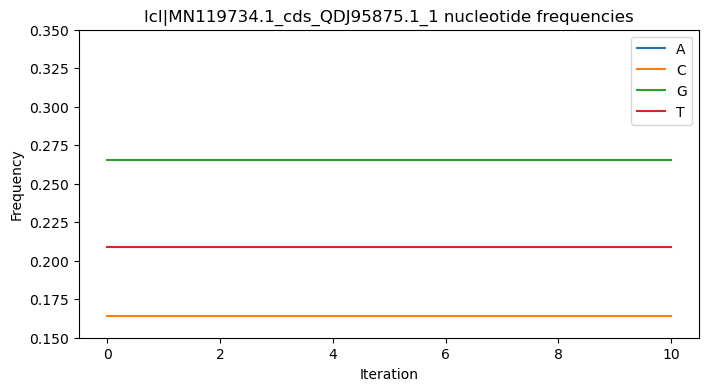

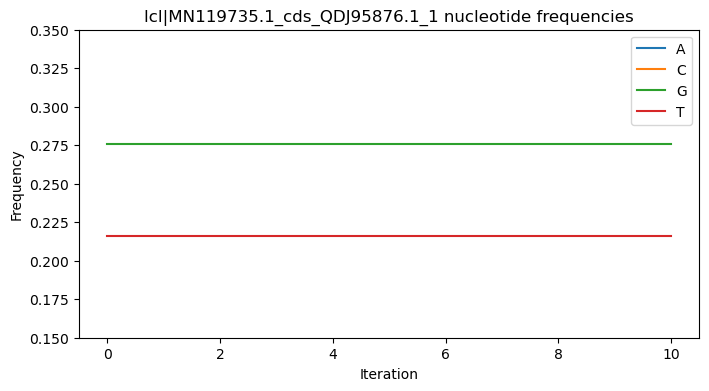

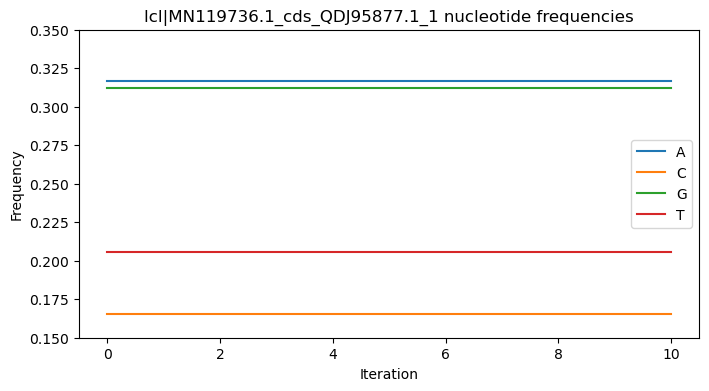

Recoded 3 sequences -> /Users/ishaharris/Projects/ribolings/data/virus/balanced_recode/Peribunya_recoded.fasta


In [ ]:
import pandas as pd
import random
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt

random.seed(1)

# ---------- Load codon swap table ----------
swap_table = pd.read_csv("/Users/ishaharris/Projects/ribolings/data/CodonSwapTable.csv")
CODON_SWAP_DICT = {}
for idx, row in swap_table.iterrows():
    n_swaps = row['Number']
    swaps = row.iloc[3:3+n_swaps].tolist()  # first 3 columns: Codon, Number, ...
    CODON_SWAP_DICT[row['Codon']] = swaps

# ---------- Utility functions ----------
def split_codons(seq):
    return [seq[i:i+3] for i in range(0, len(seq), 3)]

def seq_from_codons(codons):
    return "".join(codons)

def nucleotide_counts(seq):
    c = Counter(seq)
    return {b: c.get(b, 0) for b in 'ACGT'}

def score_balance(counts, length):
    target = length / 4
    return sum((counts[b]-target)**2 for b in 'ACGT')

# ---------- Recode with tracking ----------
def recode_seq_with_tracking(seq, passes=10):
    codons = split_codons(seq.upper())
    length = len(seq)
    cur_counts = nucleotide_counts(seq)
    freq_history = []

    for _ in range(passes):
        # record frequencies at start of this pass
        freq_history.append({b: cur_counts[b]/length for b in 'ACGT'})
        order = list(range(len(codons)-1))  # keep last codon fixed
        random.shuffle(order)
        for i in order:
            cod = codons[i]
            swaps = CODON_SWAP_DICT.get(cod, [cod])
            if len(swaps) <= 1:
                continue
            best_codon = cod
            best_score = score_balance(cur_counts, length)
            for candidate in swaps:
                if candidate == cod:
                    continue
                temp_counts = cur_counts.copy()
                for old, new in zip(cod, candidate):
                    temp_counts[old] -= 1
                    temp_counts[new] += 1
                temp_score = score_balance(temp_counts, length)
                if temp_score < best_score:
                    best_score = temp_score
                    best_codon = candidate
            if best_codon != cod:
                for old, new in zip(cod, best_codon):
                    cur_counts[old] -= 1
                    cur_counts[new] += 1
                codons[i] = best_codon

    # final frequencies
    freq_history.append({b: cur_counts[b]/length for b in 'ACGT'})
    return seq_from_codons(codons), pd.DataFrame(freq_history)

# ---------- Jupyter wrapper ----------
def recode_fasta_with_plot(input_fasta, output_folder, passes=10):
    input_path = Path(input_fasta)
    output_path = Path(output_folder)
    output_path.mkdir(exist_ok=True, parents=True)

    recoded_records = []
    for record in SeqIO.parse(str(input_path), "fasta"):
        if len(record.seq) % 3 != 0:
            print(f"Skipping {record.id} (length not divisible by 3)")
            continue
        recoded_seq, freq_df = recode_seq_with_tracking(str(record.seq), passes=passes)
        recoded_records.append(SeqRecord(Seq(recoded_seq), id=record.id, description="recoded_balanced"))

        # ---------- Plot nucleotide frequencies ----------
        freq_df.plot(figsize=(8,4), ylim=(0.15,0.35), title=f"{record.id} nucleotide frequencies")
        plt.xlabel("Iteration")
        plt.ylabel("Frequency")
        plt.show()

    output_file = output_path / f"{input_path.stem}_recoded.fasta"
    SeqIO.write(recoded_records, str(output_file), "fasta")
    print(f"Recoded {len(recoded_records)} sequences -> {output_file}")
    return recoded_records

# ---------- Example usage ----------
input_fasta = "/Users/ishaharris/Projects/ribolings/data/virus/rna_cds_fasta/Peribunya.fasta"      # your input FASTA
output_folder = "/Users/ishaharris/Projects/ribolings/data/virus/balanced_recode"       # folder to save recoded sequences

recoded_seqs = recode_fasta_with_plot(input_fasta, output_folder, passes=10)


Successfully loaded monoenrich table from '/Users/ishaharris/Projects/ribolings/data/MonoEnrichTable.csv'.

--- Starting Recoding Process (Stable Hybrid Method) ---

>>> Processing 'lcl|MN119734.1_cds_QDJ95875.1_1' (Length: 6678 bp)
Pass 1 (Target: 'C'): Changed 666 codons.
Pass 2 (Target: 'T'): Changed 378 codons.
Pass 3 (Target: 'G'): Changed 110 codons.
Pass 4 (Target: 'C'): Changed 39 codons.
Pass 5 (Target: 'T'): Changed 14 codons.
Pass 6 (Target: 'G'): Changed 3 codons.
Pass 7 (Target: 'C'): Changed 1 codons.
Pass 8 (Target: 'G'): Changed 0 codons.
Convergence reached. Stopping early.


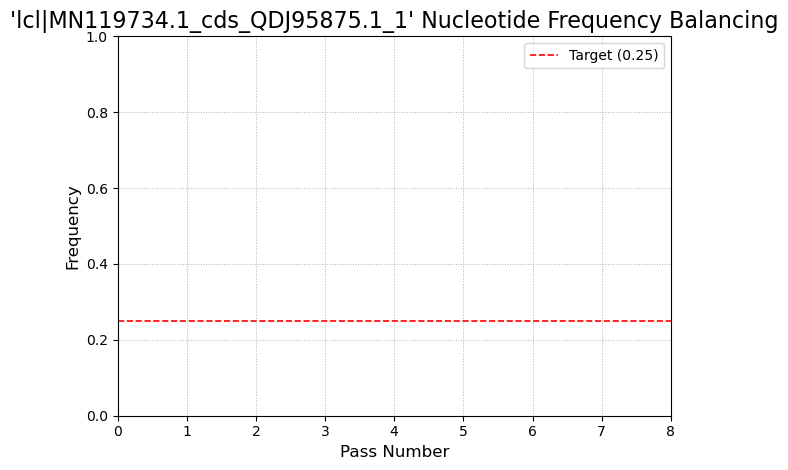


>>> Processing 'lcl|MN119735.1_cds_QDJ95876.1_1' (Length: 3375 bp)
Pass 1 (Target: 'C'): Changed 385 codons.
Pass 2 (Target: 'T'): Changed 190 codons.
Pass 3 (Target: 'G'): Changed 39 codons.
Pass 4 (Target: 'C'): Changed 18 codons.
Pass 5 (Target: 'T'): Changed 4 codons.
Pass 6 (Target: 'A'): Changed 1 codons.
Pass 7 (Target: 'C'): Changed 0 codons.
Convergence reached. Stopping early.


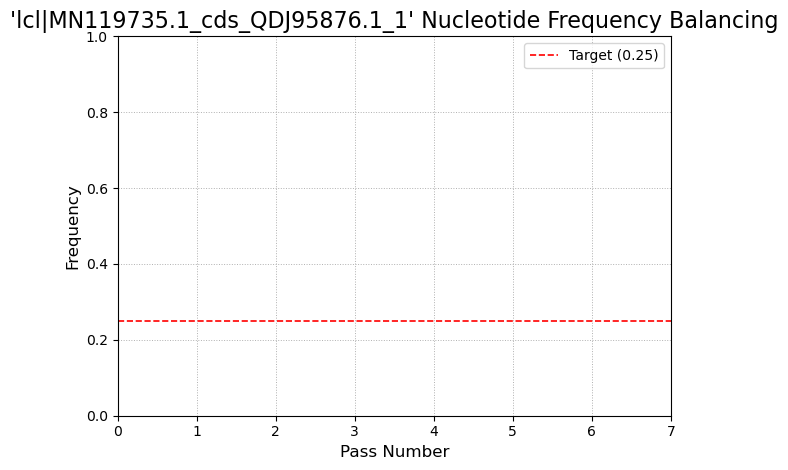


>>> Processing 'lcl|MN119736.1_cds_QDJ95877.1_1' (Length: 714 bp)
Pass 1 (Target: 'C'): Changed 62 codons.
Pass 2 (Target: 'T'): Changed 38 codons.
Pass 3 (Target: 'A'): Changed 10 codons.
Pass 4 (Target: 'C'): Changed 5 codons.
Pass 5 (Target: 'T'): Changed 2 codons.
Pass 6 (Target: 'A'): Changed 1 codons.
Pass 7 (Target: 'T'): Changed 0 codons.
Convergence reached. Stopping early.


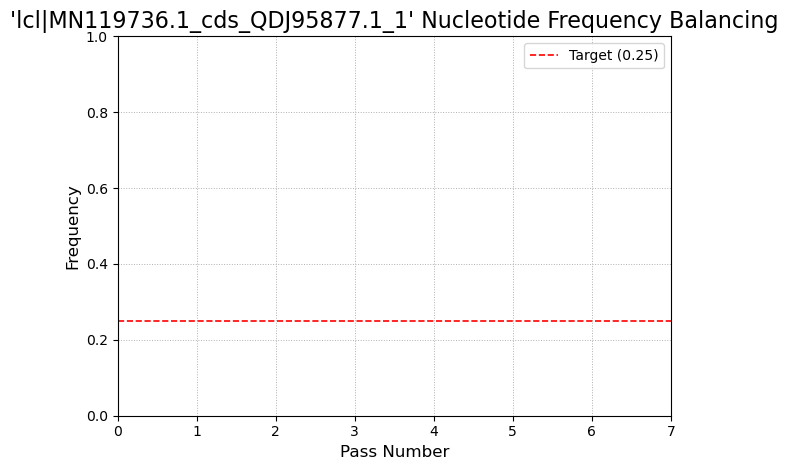


--- Process Complete ---
Successfully recoded 3 sequences.
Output saved to -> /Users/ishaharris/Projects/ribolings/data/virus/balanced_recode_hybrid/Peribunya_recoded_hybrid.fasta


In [3]:
# --- Synonymous Recoding Script for Jupyter Notebook (Stable Hybrid Method) ---
# This version combines the monoenrich table for suggestions and a scoring
# function for verification, preventing oscillations and ensuring smooth convergence.

import pandas as pd
import random
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt
import os

# Set a seed for reproducibility
random.seed(42)

# ---------- 1. CONFIGURATION ----------
# Please update these paths to your actual file locations.
MONOENRICH_TABLE_PATH = "/Users/ishaharris/Projects/ribolings/data/MonoEnrichTable.csv"
INPUT_FASTA_PATH = "/Users/ishaharris/Projects/ribolings/data/virus/rna_cds_fasta/Peribunya.fasta"
OUTPUT_FOLDER_PATH = "/Users/ishaharris/Projects/ribolings/data/virus/balanced_recode_hybrid"


# ---------- 2. Function Definitions ----------

def load_monoenrich_dict(filepath):
    """Loads the monoenrich table into a nested dictionary for fast lookups."""
    filepath = Path(filepath)
    if not filepath.is_file():
        print(f"--- ERROR: File Not Found ---\nPath: '{filepath}'\nPlease check the MONOENRICH_TABLE_PATH.")
        return None

    df = pd.read_csv(filepath)
    mono_dict = {}
    for _, row in df.iterrows():
        codon = row['Codon'].upper()
        mono_dict[codon] = {
            'A': row['Arich'].upper(),
            'C': row['Crich'].upper(),
            'G': row['Grich'].upper(),
            'T': row['Trich'].upper(),
        }
    print(f"Successfully loaded monoenrich table from '{filepath}'.")
    return mono_dict

def split_codons(seq):
    return [seq[i:i + 3] for i in range(0, len(seq), 3)]

def seq_from_codons(codons):
    return "".join(codons)

def nucleotide_counts(seq):
    c = Counter(seq)
    return {base: c.get(base, 0) for base in 'ACGT'}

def score_balance(counts, length):
    """Scores nucleotide balance. Lower is better."""
    target = length / 4.0
    return sum((counts[base] - target) ** 2 for base in 'ACGT')

def recode_seq_hybrid(seq, mono_dict, passes=20):
    """
    Recodes a sequence using a stable hybrid method. It uses the monoenrich table
    to propose a swap, but only accepts it if it improves the overall balance score.
    """
    codons = split_codons(seq.upper())
    length = len(seq)
    current_counts = nucleotide_counts(seq)
    freq_history = []
    
    for pass_num in range(passes):
        freq_history.append({base: current_counts[base] / length for base in 'ACGT'})
        codons_changed_in_pass = 0

        # Determine the nucleotide with the lowest frequency to target for enrichment.
        min_freq = min(current_counts.values())
        deficient_nucs = [nuc for nuc, count in current_counts.items() if count == min_freq]
        target_nuc = random.choice(deficient_nucs)
        
        order = list(range(len(codons) - 1))
        random.shuffle(order)

        for i in order:
            original_codon = codons[i]
            
            # 1. SUGGEST: Get a potential swap from the monoenrich table.
            if original_codon not in mono_dict:
                continue
            suggested_swap = mono_dict[original_codon][target_nuc]
            
            if suggested_swap == original_codon:
                continue

            # 2. VERIFY: Check if this swap actually improves the score.
            current_score = score_balance(current_counts, length)
            
            # Calculate what the counts would be after the swap.
            temp_counts = current_counts.copy()
            for old_nuc, new_nuc in zip(original_codon, suggested_swap):
                temp_counts[old_nuc] -= 1
                temp_counts[new_nuc] += 1
            
            new_score = score_balance(temp_counts, length)
            
            # 3. COMMIT: Only make the change if it's a real improvement.
            if new_score < current_score:
                codons_changed_in_pass += 1
                codons[i] = suggested_swap
                # Make the count change permanent for the next iteration in this pass.
                current_counts = temp_counts
        
        print(f"Pass {pass_num + 1} (Target: '{target_nuc}'): Changed {codons_changed_in_pass} codons.")
        if codons_changed_in_pass == 0 and pass_num > 0:
            print("Convergence reached. Stopping early.")
            break
            
    freq_history.append({base: current_counts[base] / length for base in 'ACGT'})
    return seq_from_codons(codons), pd.DataFrame(freq_history)

def recode_fasta_and_plot(input_fasta_path, output_folder_path, mono_dict, passes=20):
    """Main function to drive the recoding and plotting."""
    input_path = Path(input_fasta_path)
    if not input_path.is_file():
        print(f"--- ERROR: Input FASTA Not Found ---\nPath: '{input_path}'\nPlease check INPUT_FASTA_PATH.")
        return

    output_path = Path(output_folder_path)
    output_path.mkdir(exist_ok=True, parents=True)
    
    recoded_records = []
    print("\n--- Starting Recoding Process (Stable Hybrid Method) ---")
    
    for record in SeqIO.parse(str(input_path), "fasta"):
        print(f"\n>>> Processing '{record.id}' (Length: {len(record.seq)} bp)")
        
        # Call the new hybrid function
        recoded_seq, freq_df = recode_seq_hybrid(str(record.seq), mono_dict, passes=passes)
        recoded_records.append(SeqRecord(Seq(recoded_seq), id=record.id, description="recoded_to_balance_hybrid"))

        # --- Plotting ---
        #         freq_df.plot(figsize=(12, 6), ylim=(0.10, 0.40), marker='o', linestyle='-', markersize=5)
        plt.title(f"'{record.id}' Nucleotide Frequency Balancing", fontsize=16)
        plt.xlabel("Pass Number", fontsize=12)
        plt.ylabel("Frequency", fontsize=12)
        plt.axhline(y=0.25, color='r', linestyle='--', linewidth=1.2, label='Target (0.25)')
        plt.legend(loc='upper right')
        plt.grid(True, which='both', linestyle=':', linewidth=0.7)
        plt.xticks(range(len(freq_df)))
        plt.tight_layout()
        plt.show()

    output_file = output_path / f"{input_path.stem}_recoded_hybrid.fasta"
    SeqIO.write(recoded_records, str(output_file), "fasta")
    print(f"\n--- Process Complete ---")
    print(f"Successfully recoded {len(recoded_records)} sequences.")
    print(f"Output saved to -> {output_file}")


# ---------- 3. Execute the Script ----------

mono_dictionary = load_monoenrich_dict(MONOENRICH_TABLE_PATH)

if mono_dictionary:
    recode_fasta_and_plot(
        input_fasta_path=INPUT_FASTA_PATH,
        output_folder_path=OUTPUT_FOLDER_PATH,
        mono_dict=mono_dictionary,
        passes=40  # More passes can be useful for this finer-grained approach
    )


Successfully loaded codon data from '/Users/ishaharris/Projects/ribolings/data/MonoEnrichTable.csv'.

--- Starting Recoding Process (Cyclical & Iterative Method) ---

>>> Processing 'lcl|AB586644.1_cds_BAL03411.1_1' (Length: 1476 bp)
--- Phase 1: Performing initial cyclical replacement ---
--- Phase 2: Starting iterative refinement ---
Pass 1: Changed 93 codons.
Pass 2: Changed 0 codons.
Convergence reached. Stopping early.


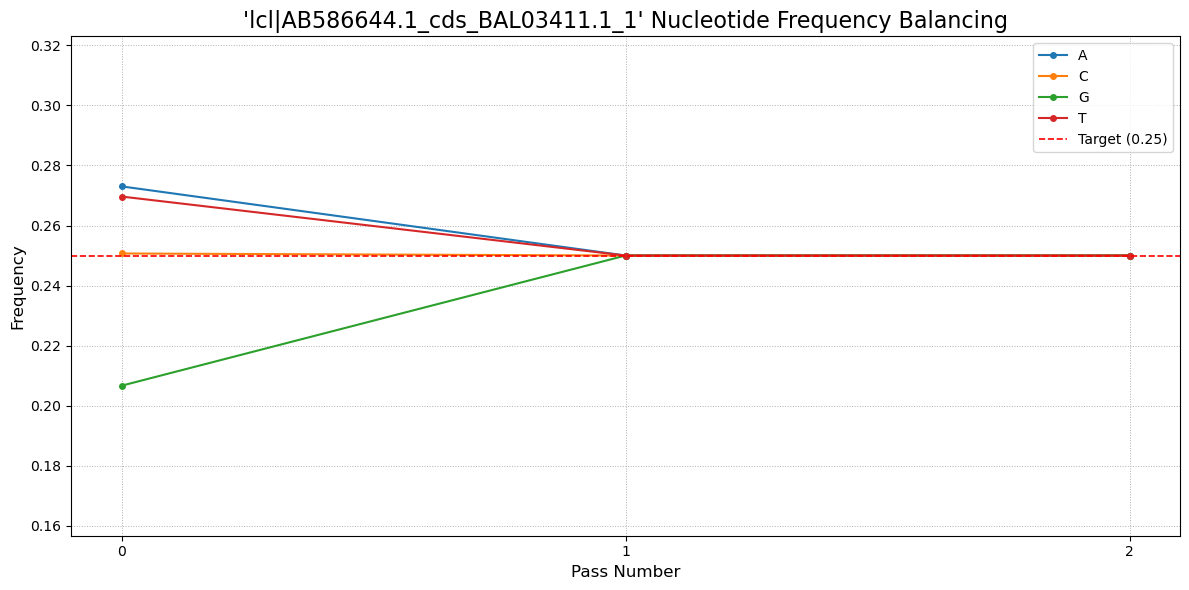


>>> Processing 'lcl|AB586644.1_cds_BAL03412.1_2' (Length: 1713 bp)
--- Phase 1: Performing initial cyclical replacement ---
--- Phase 2: Starting iterative refinement ---
Pass 1: Changed 82 codons.
Pass 2: Changed 0 codons.
Convergence reached. Stopping early.


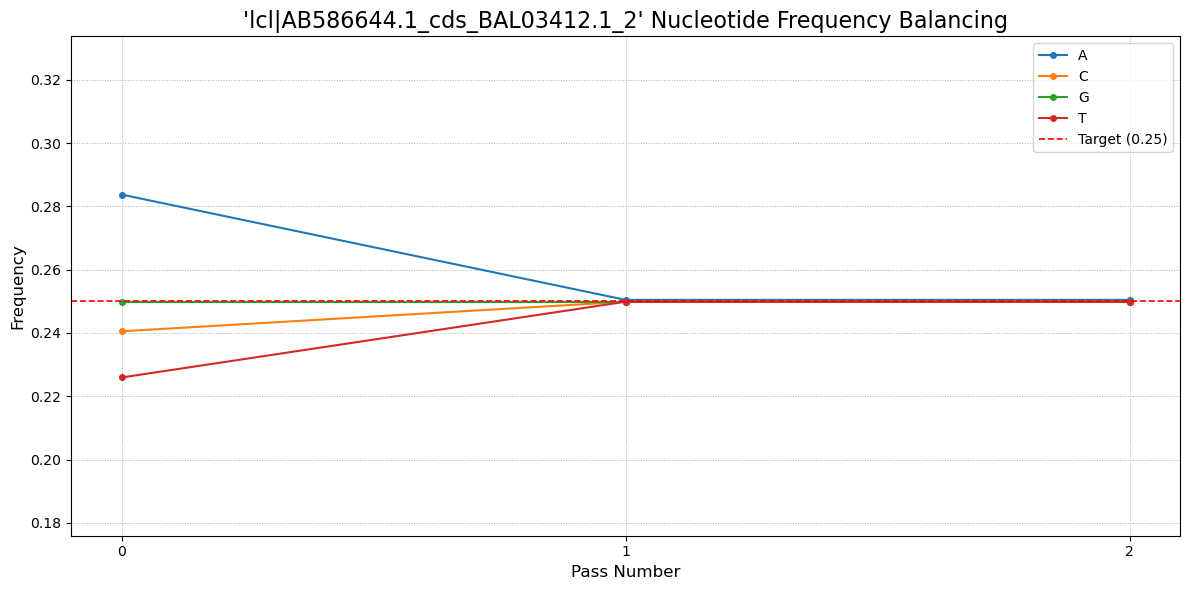


>>> Processing 'lcl|AB586645.1_cds_BAL03413.1_1' (Length: 297 bp)
--- Phase 1: Performing initial cyclical replacement ---
--- Phase 2: Starting iterative refinement ---
Pass 1: Changed 20 codons.
Pass 2: Changed 0 codons.
Convergence reached. Stopping early.


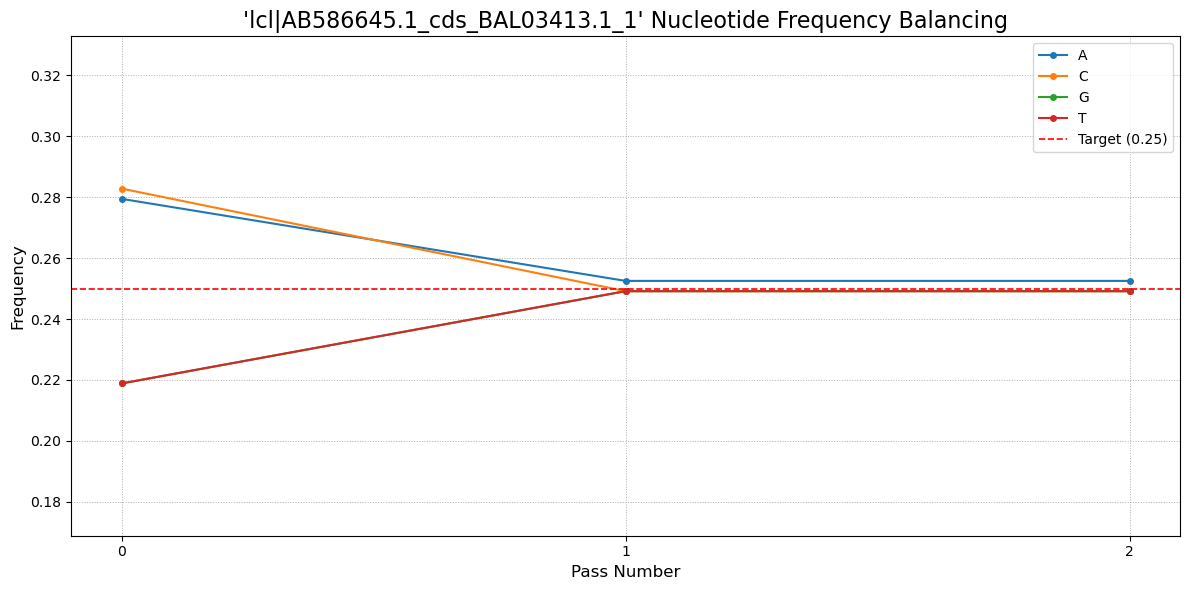


>>> Processing 'lcl|AB586645.1_cds_BAL03414.1_2' (Length: 6648 bp)
--- Phase 1: Performing initial cyclical replacement ---
--- Phase 2: Starting iterative refinement ---
Pass 1: Changed 458 codons.
Pass 2: Changed 0 codons.
Convergence reached. Stopping early.


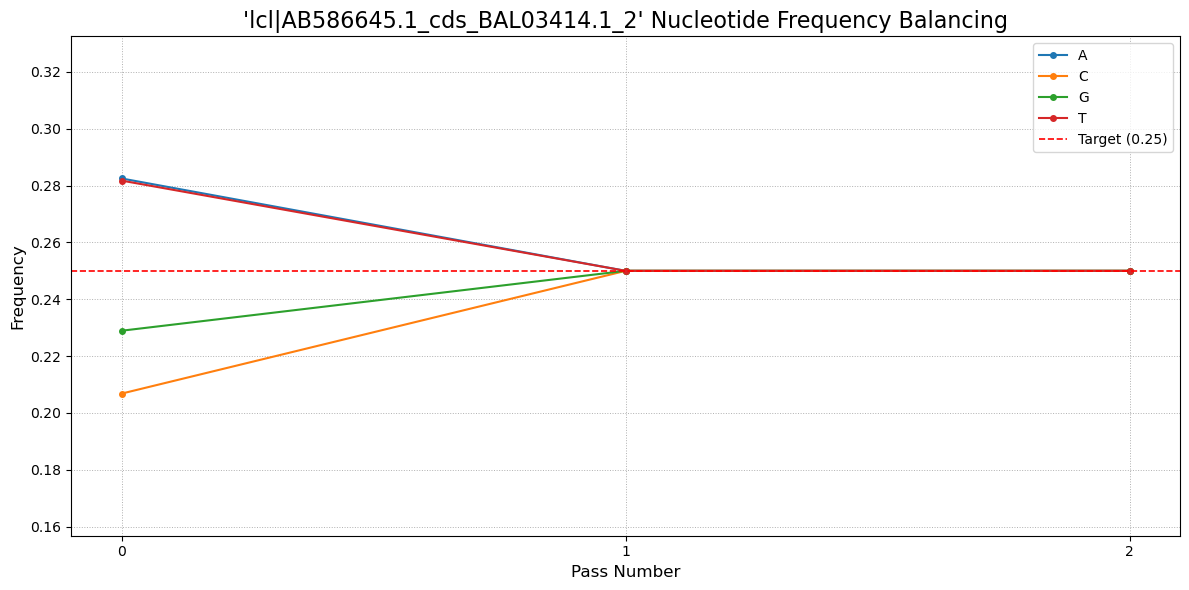


>>> Processing 'lcl|AB693150.1_cds_BAM45328.1_1' (Length: 1488 bp)
--- Phase 1: Performing initial cyclical replacement ---
--- Phase 2: Starting iterative refinement ---
Pass 1: Changed 99 codons.
Pass 2: Changed 0 codons.
Convergence reached. Stopping early.


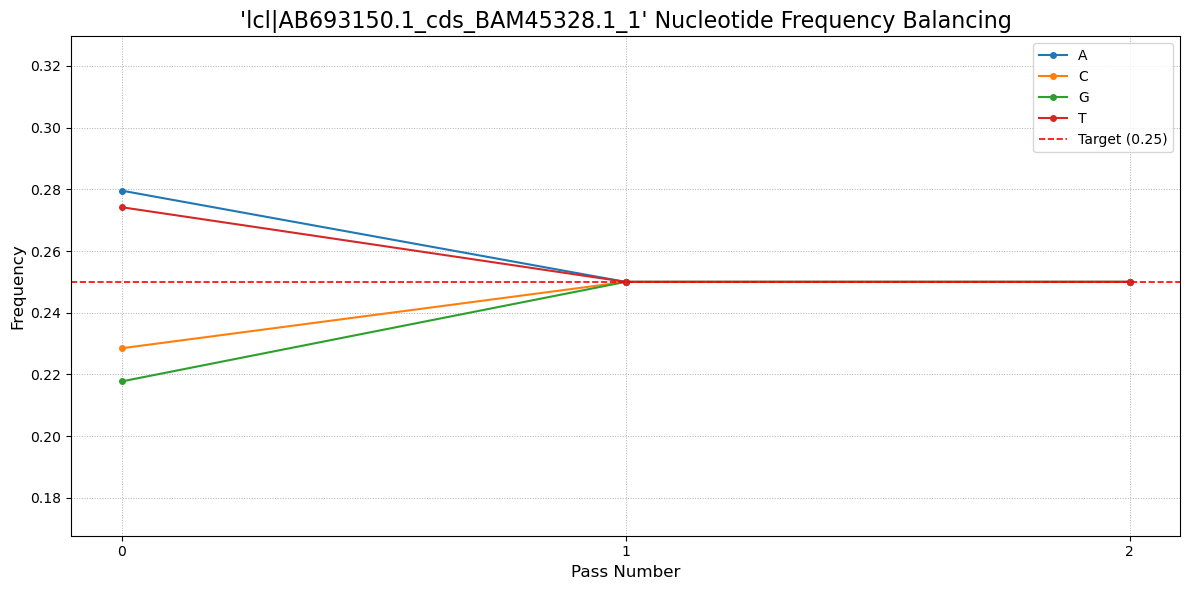


>>> Processing 'lcl|AB693150.1_cds_BAM45329.1_2' (Length: 1677 bp)
--- Phase 1: Performing initial cyclical replacement ---
--- Phase 2: Starting iterative refinement ---
Pass 1: Changed 97 codons.
Pass 2: Changed 0 codons.
Convergence reached. Stopping early.


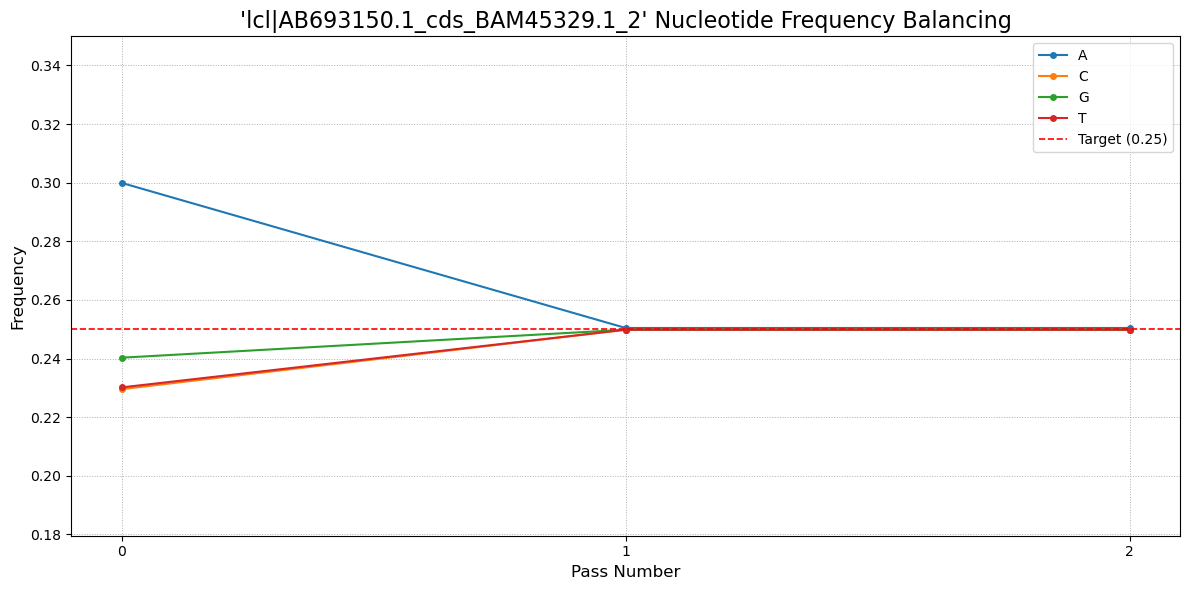


>>> Processing 'lcl|AB693151.1_cds_BAM45330.1_1' (Length: 282 bp)
--- Phase 1: Performing initial cyclical replacement ---
--- Phase 2: Starting iterative refinement ---
Pass 1: Changed 16 codons.
Pass 2: Changed 0 codons.
Convergence reached. Stopping early.


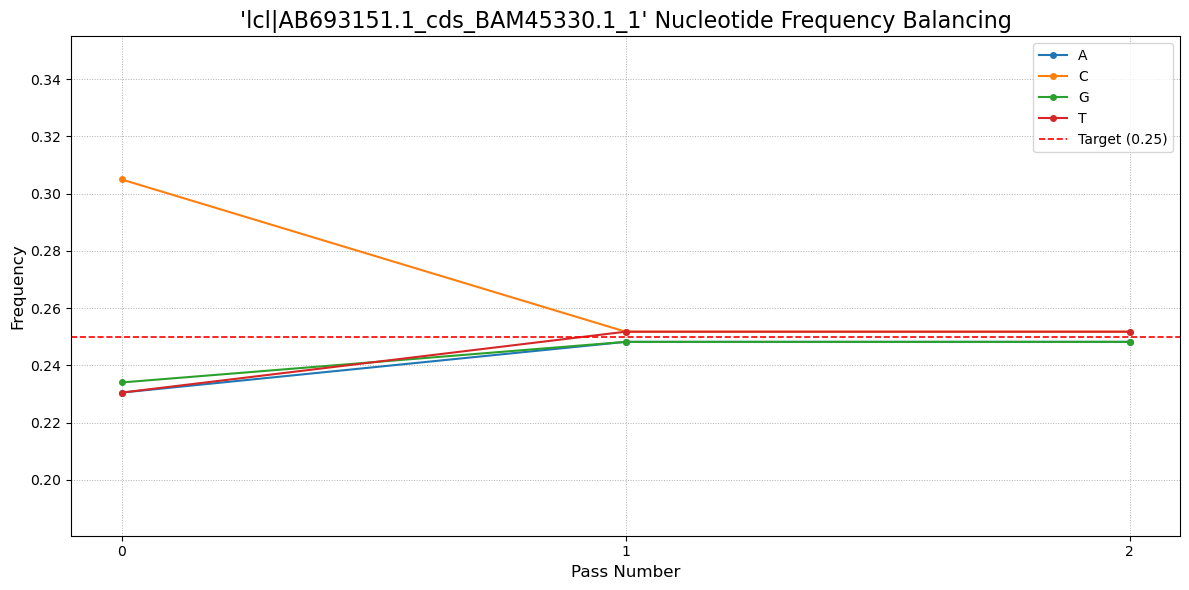


>>> Processing 'lcl|AB693151.1_cds_BAM45331.1_2' (Length: 6246 bp)
--- Phase 1: Performing initial cyclical replacement ---
--- Phase 2: Starting iterative refinement ---
Pass 1: Changed 424 codons.
Pass 2: Changed 0 codons.
Convergence reached. Stopping early.


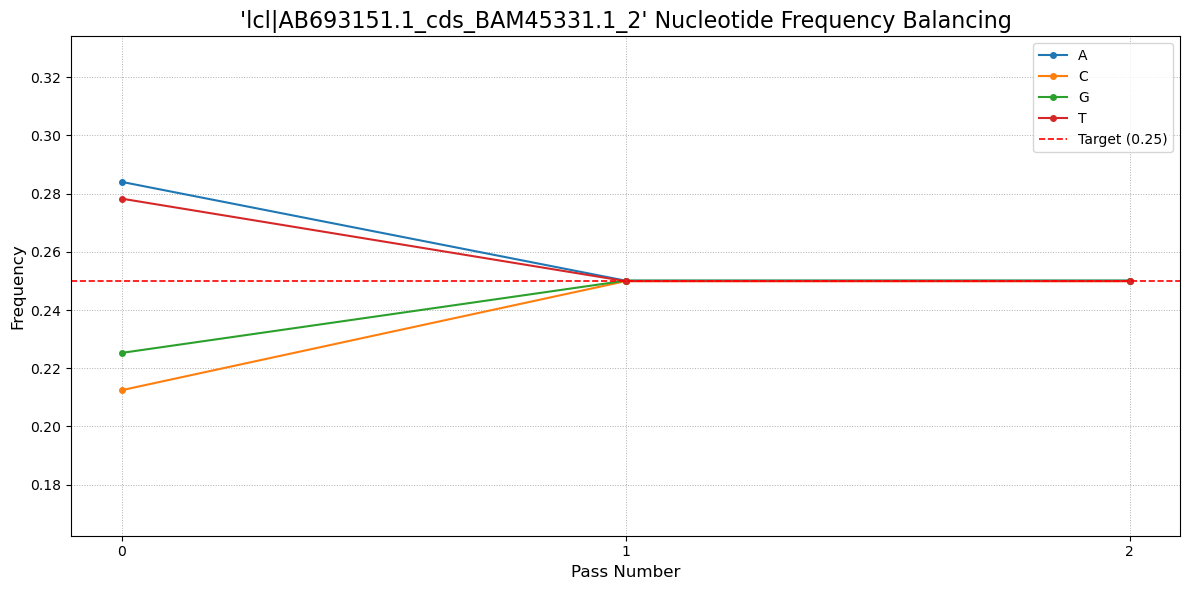


>>> Processing 'lcl|AB972428.1_cds_BAU22152.1_1' (Length: 1482 bp)
--- Phase 1: Performing initial cyclical replacement ---
--- Phase 2: Starting iterative refinement ---
Pass 1: Changed 127 codons.
Pass 2: Changed 0 codons.
Convergence reached. Stopping early.


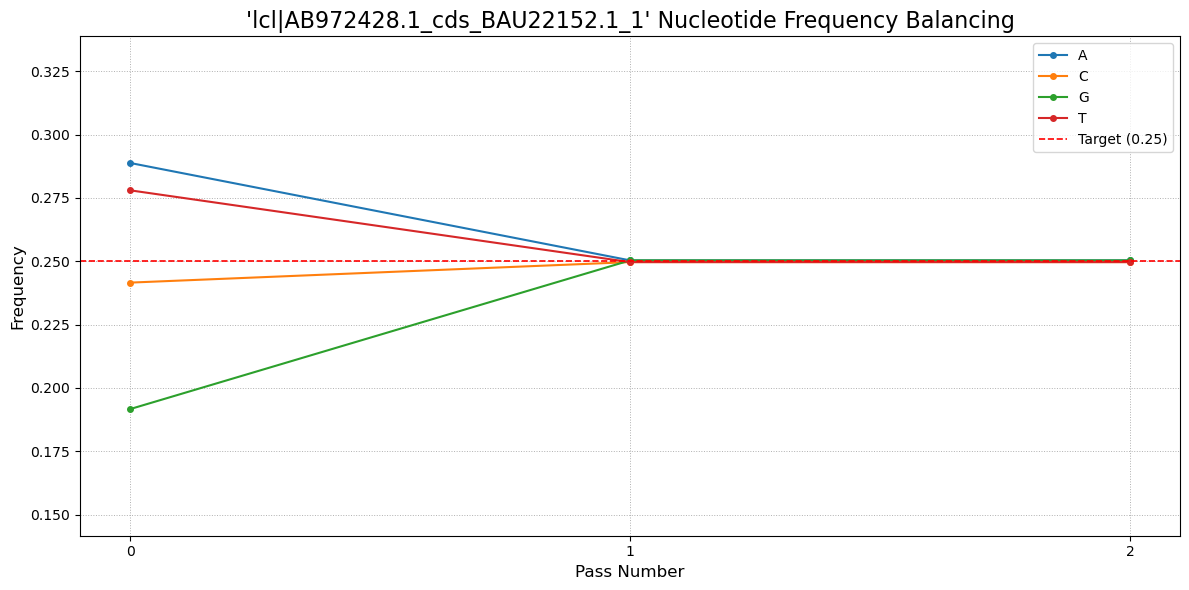


>>> Processing 'lcl|AB972429.1_cds_BAU22153.1_1' (Length: 300 bp)
--- Phase 1: Performing initial cyclical replacement ---
--- Phase 2: Starting iterative refinement ---
Pass 1: Changed 27 codons.
Pass 2: Changed 0 codons.
Convergence reached. Stopping early.


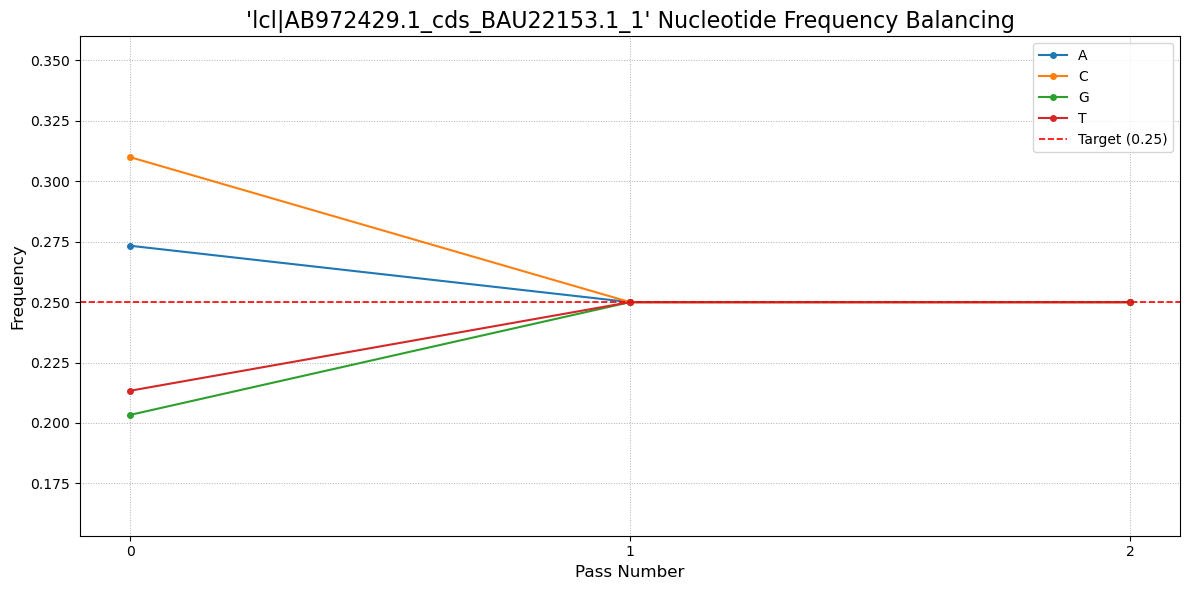


>>> Processing 'lcl|AB972430.1_cds_BAU22154.1_1' (Length: 1476 bp)
--- Phase 1: Performing initial cyclical replacement ---
--- Phase 2: Starting iterative refinement ---
Pass 1: Changed 90 codons.
Pass 2: Changed 0 codons.
Convergence reached. Stopping early.


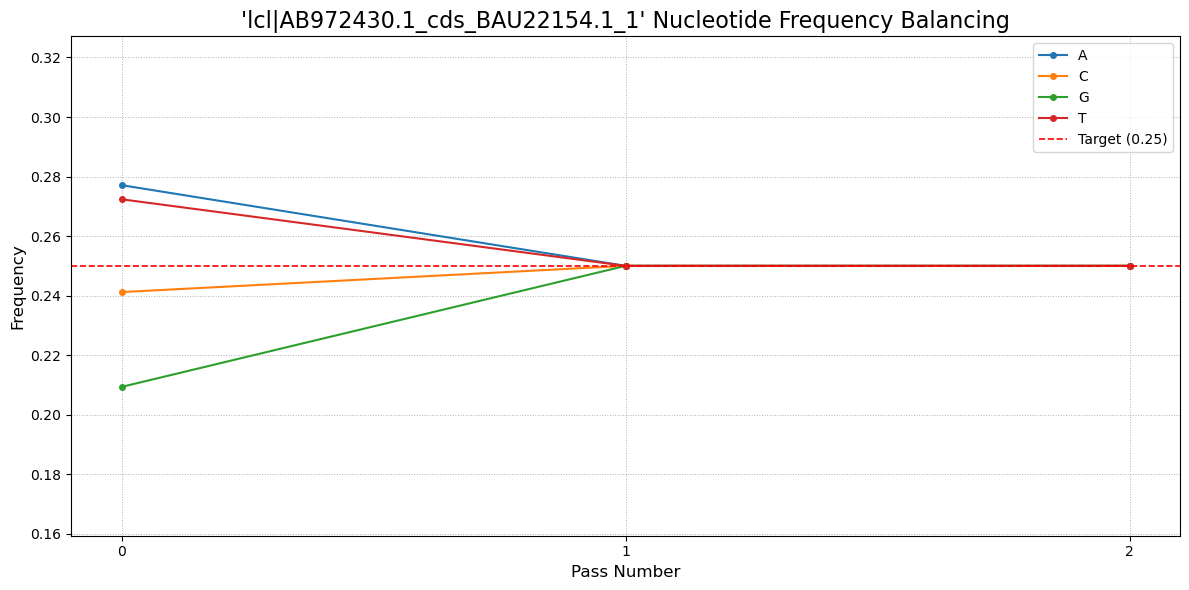


>>> Processing 'lcl|AB972431.1_cds_BAU22155.1_1' (Length: 297 bp)
--- Phase 1: Performing initial cyclical replacement ---
--- Phase 2: Starting iterative refinement ---
Pass 1: Changed 27 codons.
Pass 2: Changed 0 codons.
Convergence reached. Stopping early.


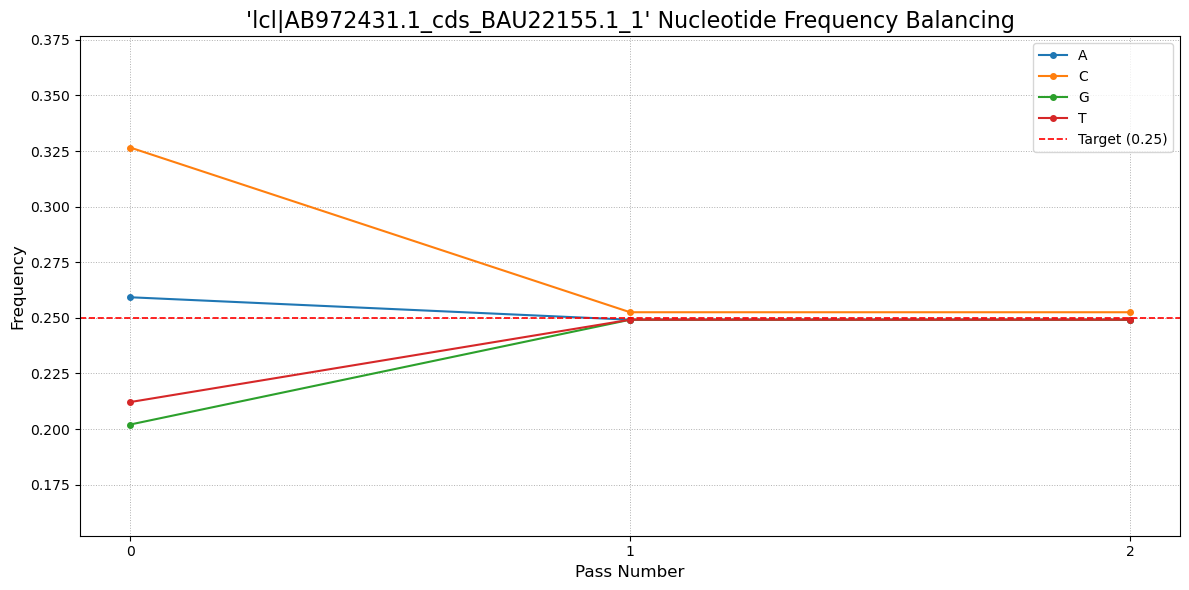


>>> Processing 'lcl|AF228063.1_cds_AAK60497.1_1' (Length: 1443 bp)
--- Phase 1: Performing initial cyclical replacement ---
--- Phase 2: Starting iterative refinement ---
Pass 1: Changed 113 codons.
Pass 2: Changed 0 codons.
Convergence reached. Stopping early.


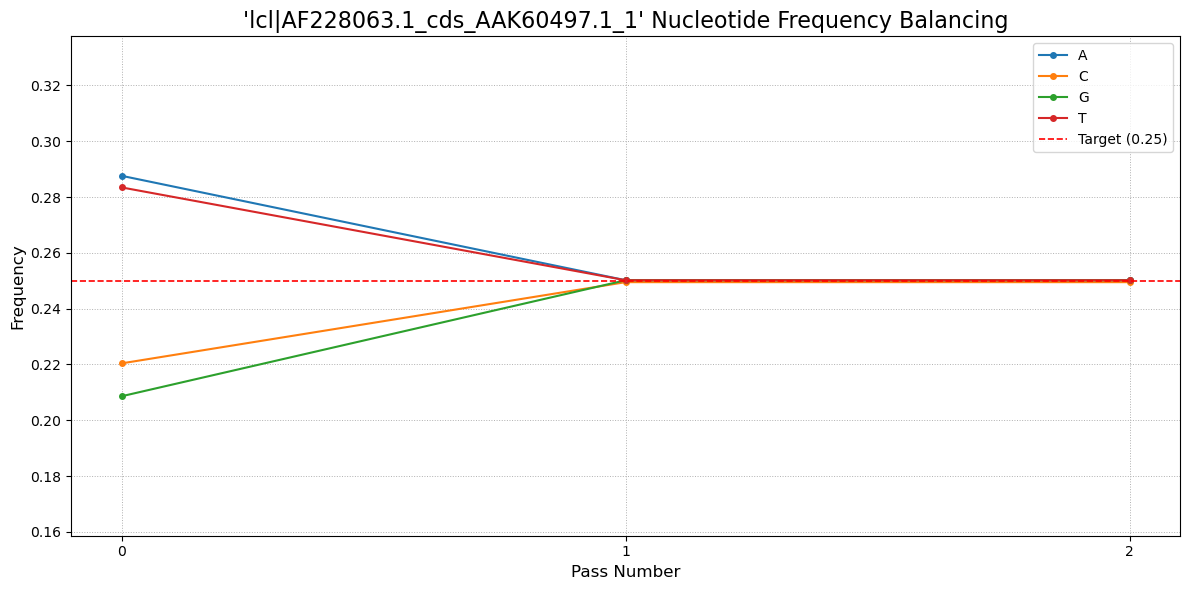


>>> Processing 'lcl|AF228063.1_cds_AAK60498.1_2' (Length: 1689 bp)
--- Phase 1: Performing initial cyclical replacement ---
--- Phase 2: Starting iterative refinement ---
Pass 1: Changed 99 codons.
Pass 2: Changed 0 codons.
Convergence reached. Stopping early.


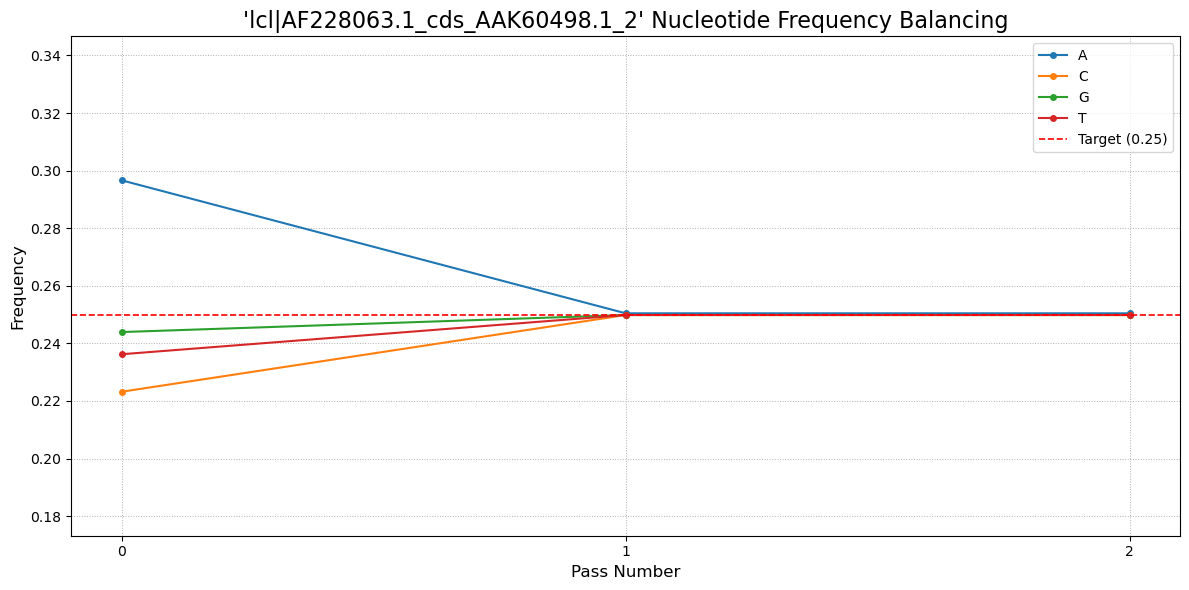


>>> Processing 'lcl|AF427517.1_cds_AAL16099.1_1' (Length: 6573 bp)
--- Phase 1: Performing initial cyclical replacement ---
--- Phase 2: Starting iterative refinement ---
Pass 1: Changed 469 codons.
Pass 2: Changed 0 codons.
Convergence reached. Stopping early.


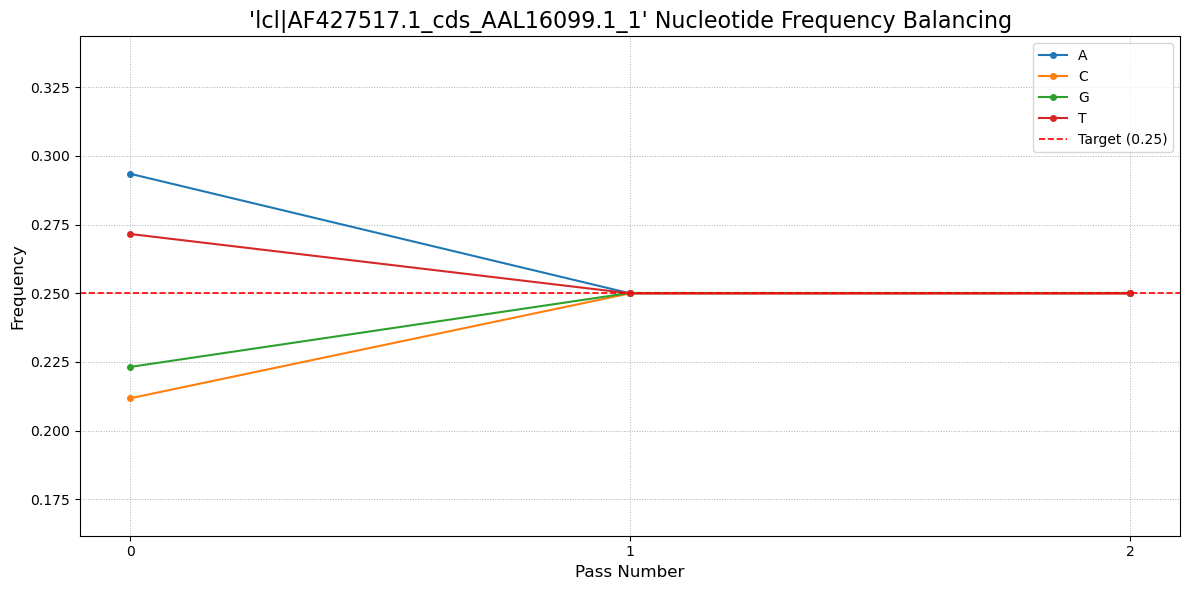


>>> Processing 'lcl|AF427517.1_cds_AAL16100.1_2' (Length: 288 bp)
--- Phase 1: Performing initial cyclical replacement ---
--- Phase 2: Starting iterative refinement ---
Pass 1: Changed 11 codons.
Pass 2: Changed 0 codons.
Convergence reached. Stopping early.


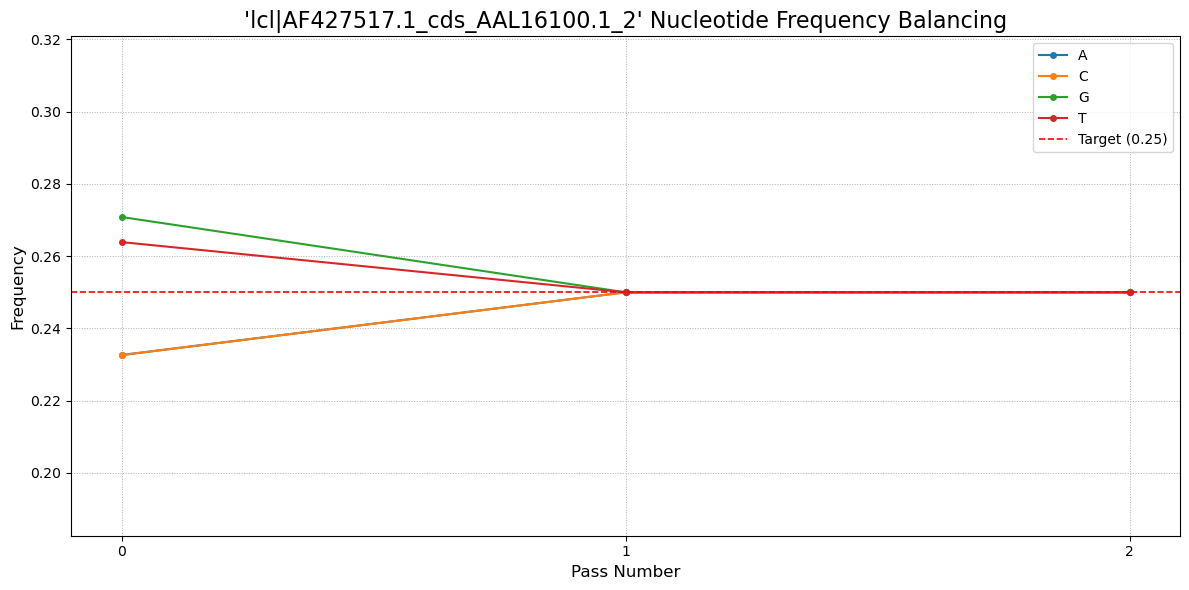


>>> Processing 'lcl|AF485256.1_cds_AAN09934.1_1' (Length: 1446 bp)
--- Phase 1: Performing initial cyclical replacement ---
--- Phase 2: Starting iterative refinement ---
Pass 1: Changed 80 codons.
Pass 2: Changed 0 codons.
Convergence reached. Stopping early.


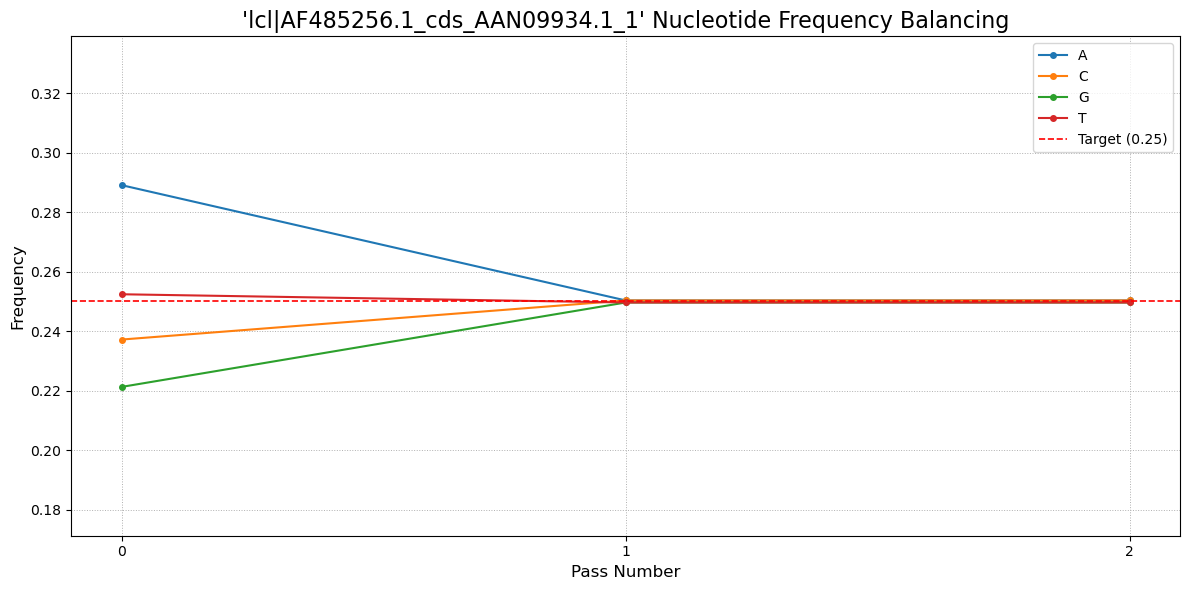


>>> Processing 'lcl|AF485256.1_cds_AAN09935.1_2' (Length: 1683 bp)
--- Phase 1: Performing initial cyclical replacement ---
--- Phase 2: Starting iterative refinement ---
Pass 1: Changed 87 codons.
Pass 2: Changed 0 codons.
Convergence reached. Stopping early.


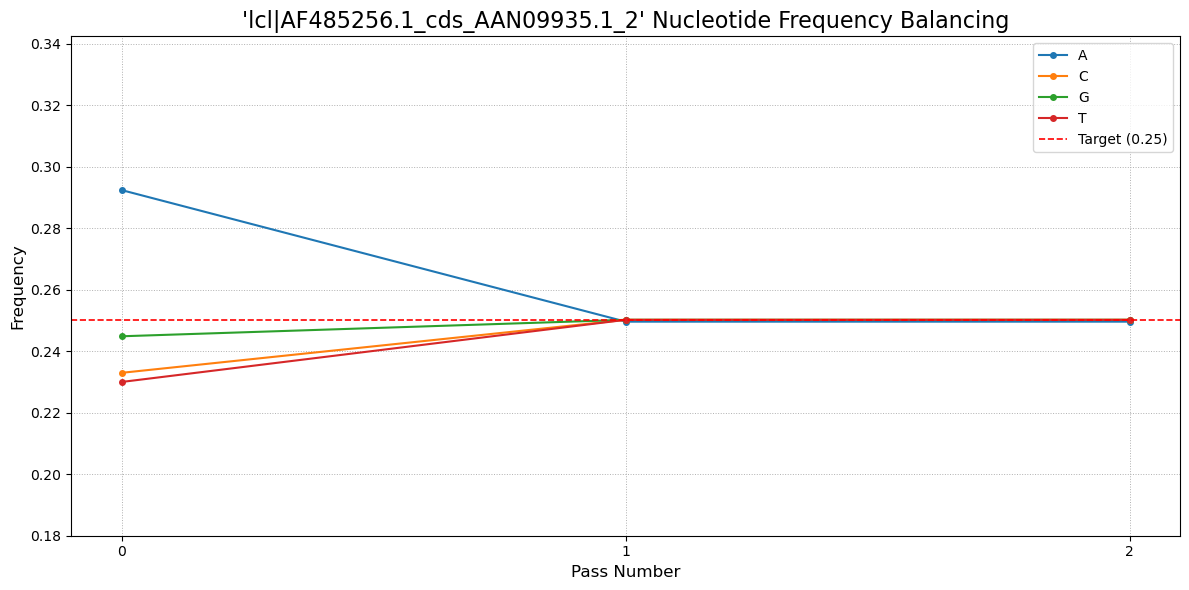


>>> Processing 'lcl|AF485261.1_cds_AAN09944.1_1' (Length: 1524 bp)
--- Phase 1: Performing initial cyclical replacement ---
--- Phase 2: Starting iterative refinement ---
Pass 1: Changed 97 codons.
Pass 2: Changed 0 codons.
Convergence reached. Stopping early.


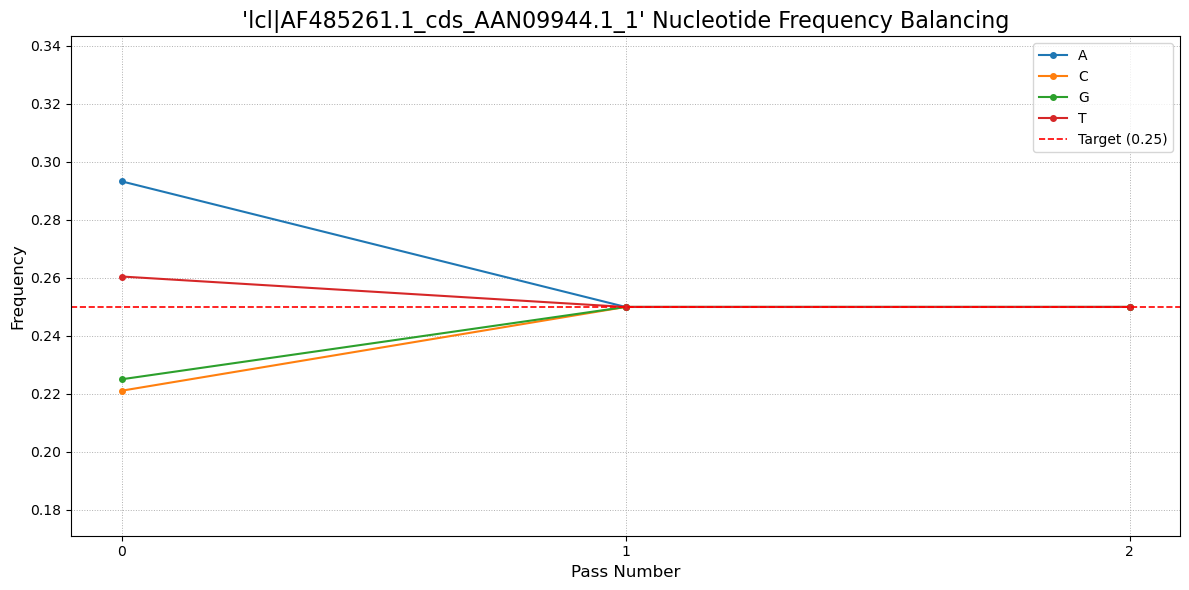


>>> Processing 'lcl|AF485261.1_cds_AAN09945.1_2' (Length: 1680 bp)
--- Phase 1: Performing initial cyclical replacement ---
--- Phase 2: Starting iterative refinement ---
Pass 1: Changed 89 codons.
Pass 2: Changed 0 codons.
Convergence reached. Stopping early.


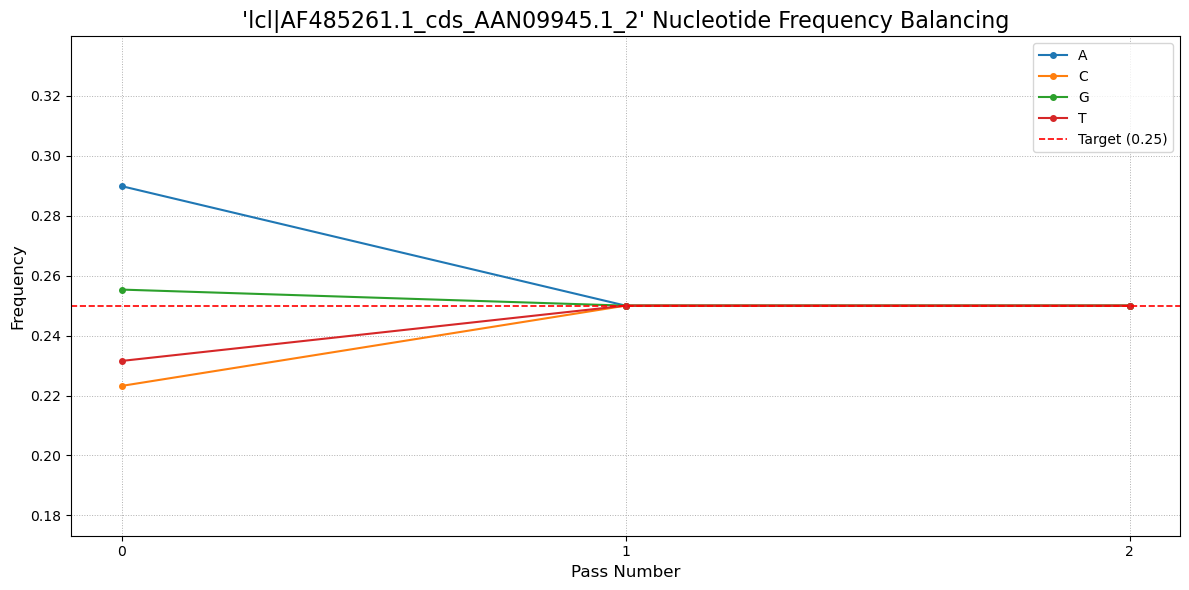


>>> Processing 'lcl|AF485262.1_cds_AAN09946.1_1' (Length: 1533 bp)
--- Phase 1: Performing initial cyclical replacement ---
--- Phase 2: Starting iterative refinement ---
Pass 1: Changed 97 codons.
Pass 2: Changed 0 codons.
Convergence reached. Stopping early.


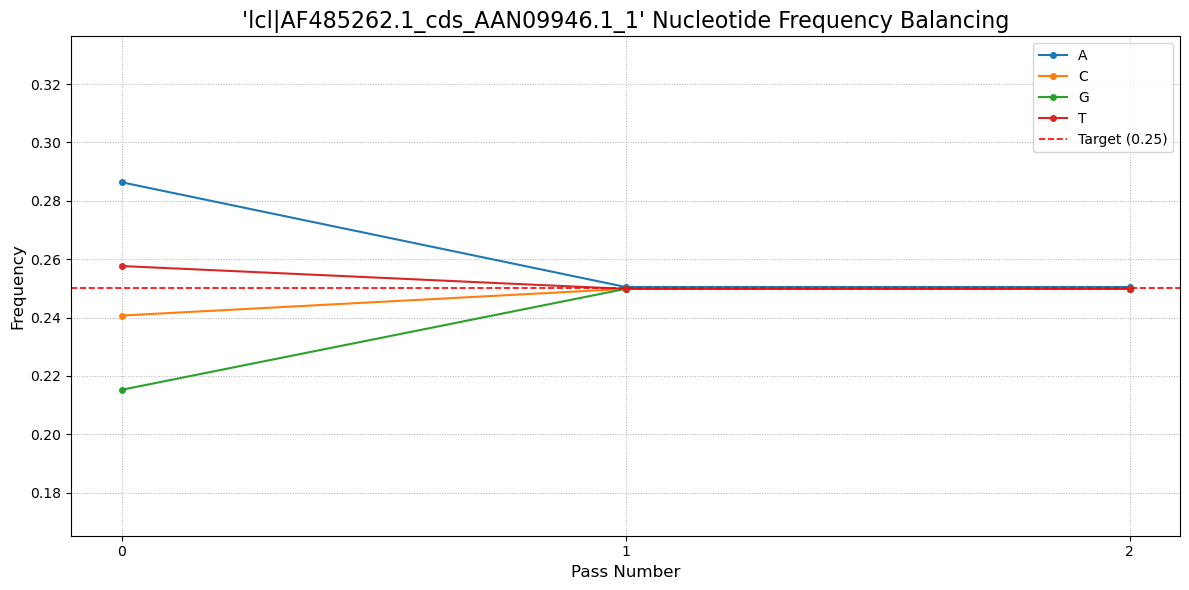


>>> Processing 'lcl|AF485262.1_cds_AAN09947.1_2' (Length: 1683 bp)
--- Phase 1: Performing initial cyclical replacement ---
--- Phase 2: Starting iterative refinement ---
Pass 1: Changed 71 codons.
Pass 2: Changed 0 codons.
Convergence reached. Stopping early.


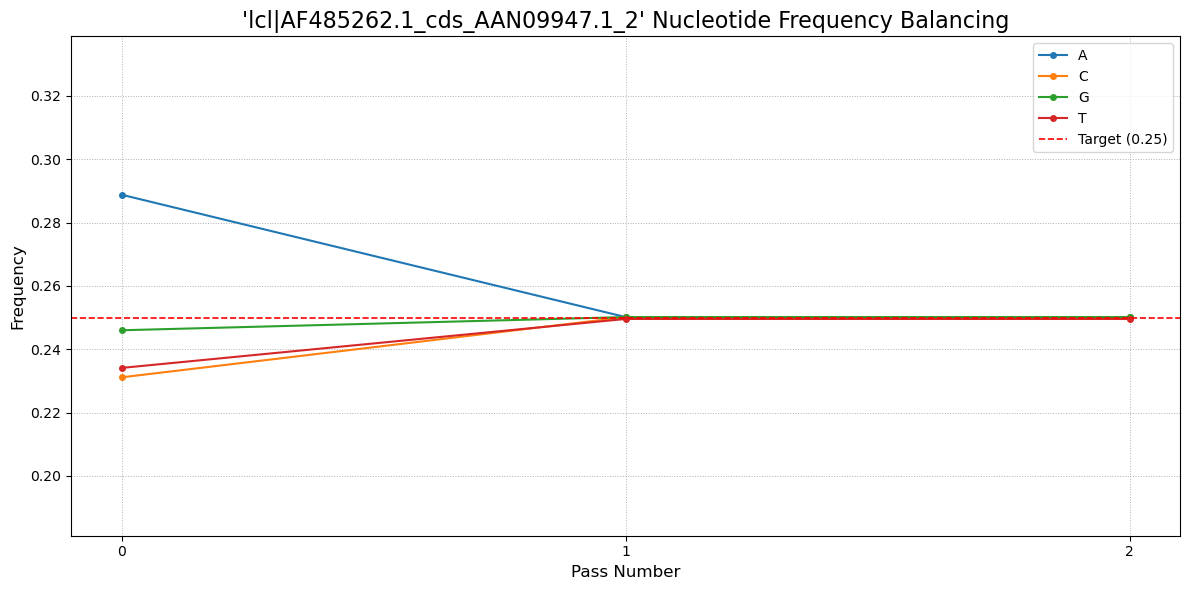


>>> Processing 'lcl|AF485263.1_cds_AAN09948.1_1' (Length: 1458 bp)
--- Phase 1: Performing initial cyclical replacement ---
--- Phase 2: Starting iterative refinement ---
Pass 1: Changed 88 codons.
Pass 2: Changed 0 codons.
Convergence reached. Stopping early.


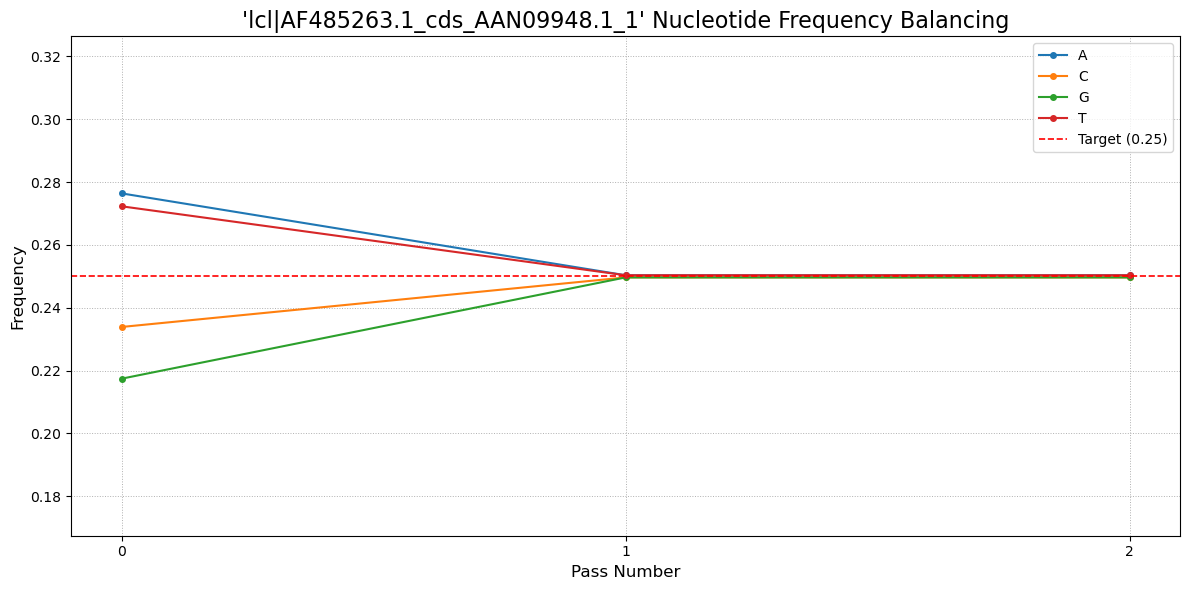


>>> Processing 'lcl|AF485263.1_cds_AAN09949.1_2' (Length: 1698 bp)
--- Phase 1: Performing initial cyclical replacement ---
--- Phase 2: Starting iterative refinement ---
Pass 1: Changed 72 codons.
Pass 2: Changed 0 codons.
Convergence reached. Stopping early.


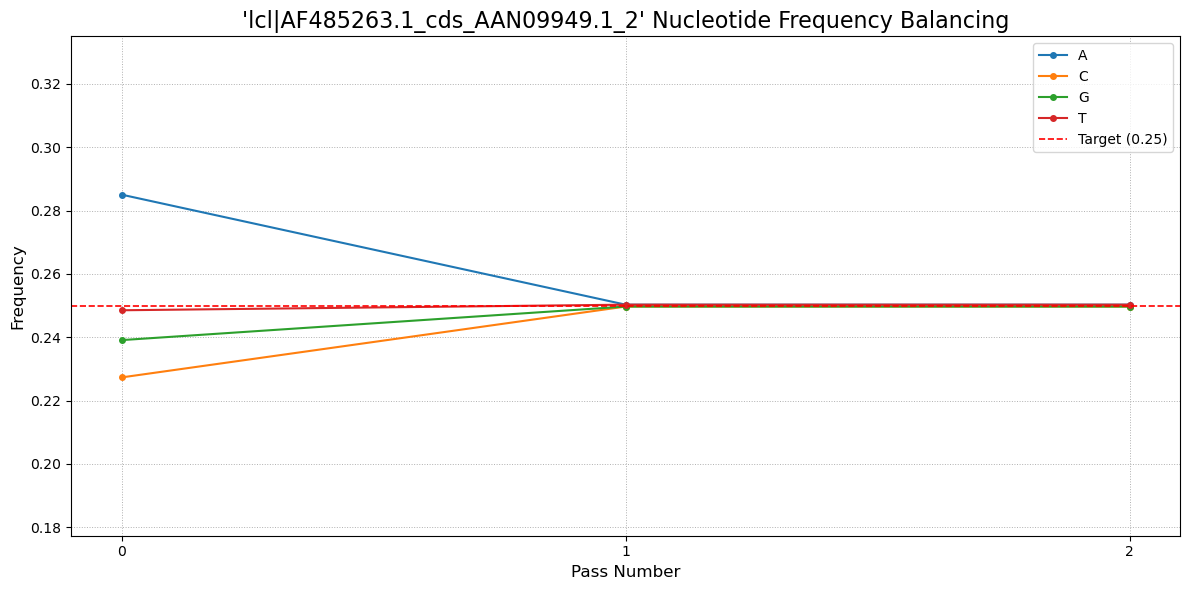


>>> Processing 'lcl|AF512830.1_cds_AAN32959.1_1' (Length: 1548 bp)
--- Phase 1: Performing initial cyclical replacement ---
--- Phase 2: Starting iterative refinement ---
Pass 1: Changed 121 codons.
Pass 2: Changed 0 codons.
Convergence reached. Stopping early.


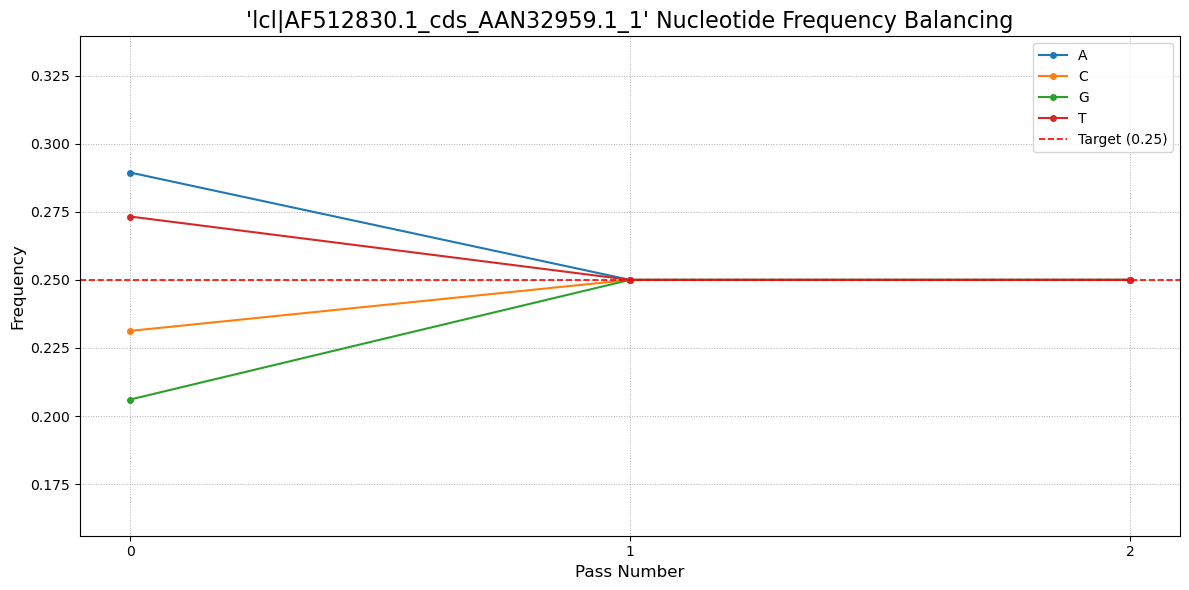


>>> Processing 'lcl|AF512830.1_cds_AAN32960.1_2' (Length: 1674 bp)
--- Phase 1: Performing initial cyclical replacement ---
--- Phase 2: Starting iterative refinement ---
Pass 1: Changed 96 codons.
Pass 2: Changed 0 codons.
Convergence reached. Stopping early.


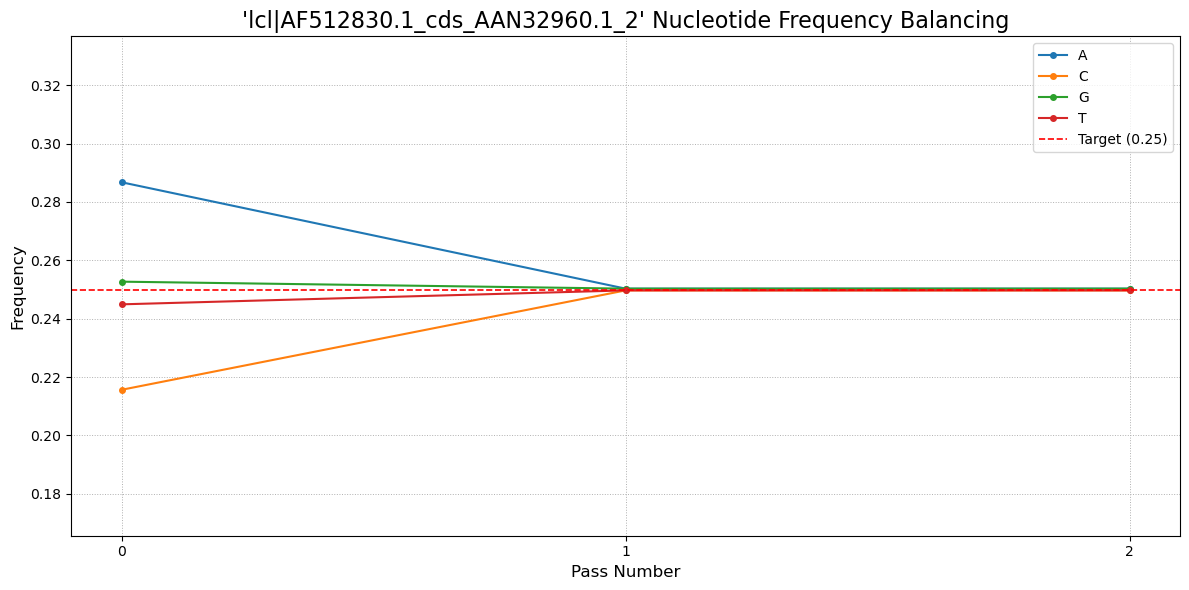


>>> Processing 'lcl|AF512831.1_cds_AAN32961.1_1' (Length: 1524 bp)
--- Phase 1: Performing initial cyclical replacement ---
--- Phase 2: Starting iterative refinement ---
Pass 1: Changed 70 codons.
Pass 2: Changed 0 codons.
Convergence reached. Stopping early.


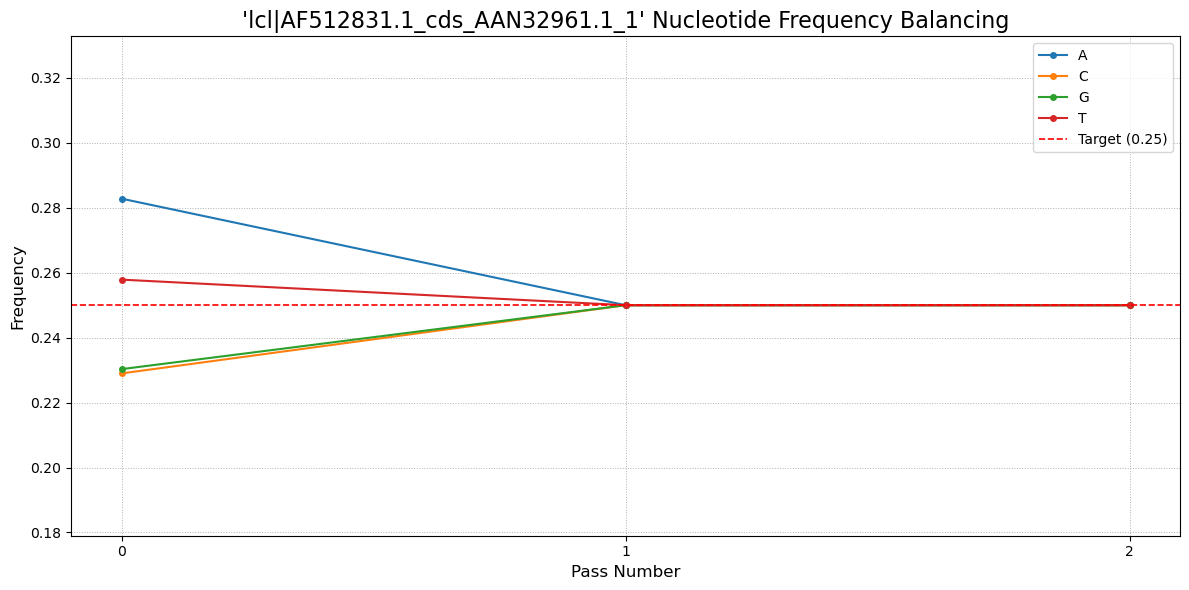


>>> Processing 'lcl|AF512831.1_cds_AAN32962.1_2' (Length: 1680 bp)
--- Phase 1: Performing initial cyclical replacement ---
--- Phase 2: Starting iterative refinement ---
Pass 1: Changed 87 codons.
Pass 2: Changed 0 codons.
Convergence reached. Stopping early.


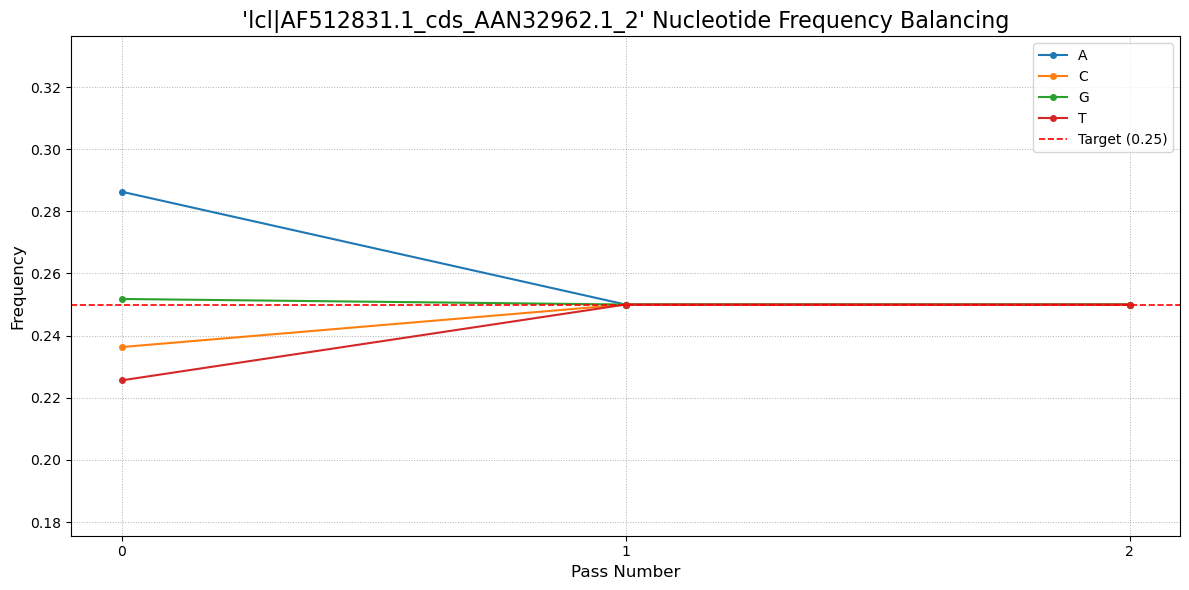


>>> Processing 'lcl|AF512832.1_cds_AAN32963.1_1' (Length: 1443 bp)
--- Phase 1: Performing initial cyclical replacement ---
--- Phase 2: Starting iterative refinement ---
Pass 1: Changed 70 codons.
Pass 2: Changed 0 codons.
Convergence reached. Stopping early.


KeyboardInterrupt: 

In [ ]:
# --- Synonymous Recoding Script for Jupyter Notebook (Cyclical & Iterative Method) ---
# This script first performs a cyclical codon replacement to create a balanced
# starting point, then iteratively refines the sequence to converge nucleotide
# frequencies towards 25% for A, C, G, and T.

import pandas as pd
import random
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from pathlib import Path
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import os

# Set a seed for reproducibility
random.seed(42)

# ---------- 1. CONFIGURATION ----------
# Please update these paths to your actual file locations.
# The codon table should have 6 columns: Codon, AA, Arich, Crich, Grich, Trich
CODON_TABLE_PATH = "/Users/ishaharris/Projects/ribolings/data/MonoEnrichTable.csv"
INPUT_FASTA_PATH = "/Users/ishaharris/Projects/ribolings/data/virus/rna_cds_fasta/Arena.fasta"
OUTPUT_FOLDER_PATH = "/Users/ishaharris/Projects/ribolings/data/virus/rna_cds_fasta/"


# ---------- 2. Function Definitions ----------

def load_codon_data(filepath):
    """
    Loads the codon table and creates dictionaries for enrichment, amino acid
    lookups, and synonymous codons.
    
    Returns:
        A tuple of dictionaries: (enrich_dict, aa_dict, synonymous_codons)
        - enrich_dict: {'codon': {'A': 'Arich_synonym', ...}}
        - aa_dict: {'codon': 'AA'}
        - synonymous_codons: {'AA': ['codon1', 'codon2', ...]}
    """
    filepath = Path(filepath)
    if not filepath.is_file():
        print(f"--- ERROR: File Not Found ---\nPath: '{filepath}'\nPlease check the CODON_TABLE_PATH.")
        return None, None, None

    df = pd.read_csv(filepath)
    enrich_dict = {}
    aa_dict = {}
    synonymous_codons = defaultdict(list)
    
    for _, row in df.iterrows():
        codon = row['Codon'].upper()
        aa = row['AA']
        
        enrich_dict[codon] = {
            'A': row['Arich'].upper(),
            'C': row['Crich'].upper(),
            'G': row['Grich'].upper(),
            'T': row['Trich'].upper(),
        }
        aa_dict[codon] = aa
        if codon not in synonymous_codons[aa]:
            synonymous_codons[aa].append(codon)
            
    print(f"Successfully loaded codon data from '{filepath}'.")
    return enrich_dict, aa_dict, dict(synonymous_codons)

def split_codons(seq):
    """Splits a sequence string into a list of codons."""
    return [seq[i:i + 3] for i in range(0, len(seq) - (len(seq) % 3), 3)]

def seq_from_codons(codons):
    """Joins a list of codons back into a sequence string."""
    return "".join(codons)

def nucleotide_counts(seq):
    """Calculates the count of each nucleotide in a sequence."""
    c = Counter(seq)
    return {base: c.get(base, 0) for base in 'ACGT'}

def score_balance(counts, length):
    """
    Scores nucleotide balance. A lower score is better, with 0 being perfect balance.
    Calculates the sum of squared differences from the target frequency (25%).
    """
    if length == 0:
        return float('inf')
    target = length / 4.0
    return sum((counts[base] - target) ** 2 for base in 'ACGT')

def recode_sequence(seq, enrich_dict, aa_dict, synonymous_codons, passes=40):
    """
    Recodes a sequence using a two-phase approach:
    1. Cyclical Pass: A deterministic first pass to quickly balance the sequence.
    2. Iterative Refinement: Subsequent passes to converge towards 25% for each nucleotide.
    """
    if not seq:
        return "", pd.DataFrame()

    original_codons = split_codons(seq.upper())
    if not original_codons:
        return "", pd.DataFrame()
        
    length = len(seq_from_codons(original_codons))
    
    # --- Phase 1: Cyclical Codon Replacement ---
    print("--- Phase 1: Performing initial cyclical replacement ---")
    cycled_codons = []
    cycle = ['A', 'C', 'G', 'T']
    for i, codon in enumerate(original_codons):
        target_nuc = cycle[i % 4]
        if codon in enrich_dict:
            new_codon = enrich_dict[codon][target_nuc]
            cycled_codons.append(new_codon)
        else:
            cycled_codons.append(codon) # Keep original if not in table
    
    codons = cycled_codons
    current_seq = seq_from_codons(codons)
    current_counts = nucleotide_counts(current_seq)
    
    # --- Phase 2: Iterative Convergence ---
    print("--- Phase 2: Starting iterative refinement ---")
    freq_history = []
    
    for pass_num in range(passes):
        # Record frequencies at the start of the pass
        freq_history.append({base: current_counts.get(base, 0) / length for base in 'ACGT'})
        codons_changed_in_pass = 0
        
        # Determine over and under-represented nucleotides
        counts_list = sorted(current_counts.items(), key=lambda item: item[1])
        min_nuc = counts_list[0][0]  # Most under-represented
        max_nuc = counts_list[-1][0] # Most over-represented
        
        if min_nuc == max_nuc:
             print("Frequencies are perfectly balanced. Stopping early.")
             break

        order = list(range(len(codons)))
        random.shuffle(order)

        for i in order:
            original_codon = codons[i]
            
            if original_codon not in aa_dict:
                continue

            # Get the list of all possible synonymous codons
            aa = aa_dict[original_codon]
            possible_swaps = synonymous_codons.get(aa, [original_codon])

            # Find the best possible swap at this position
            best_swap = original_codon
            current_score = score_balance(current_counts, length)
            best_new_score = current_score

            for suggested_swap in possible_swaps:
                if suggested_swap == original_codon:
                    continue

                # Temporarily apply the swap to calculate its effect
                temp_counts = current_counts.copy()
                for old_nuc, new_nuc in zip(original_codon, suggested_swap):
                    temp_counts[old_nuc] -= 1
                    temp_counts[new_nuc] += 1
                
                new_score = score_balance(temp_counts, length)
                
                # Check if this swap is the best improvement we've seen so far
                if new_score < best_new_score:
                    best_new_score = new_score
                    best_swap = suggested_swap

            # If a beneficial swap was found, commit it
            if best_swap != original_codon:
                codons[i] = best_swap
                # Update counts permanently for this pass
                for old_nuc, new_nuc in zip(original_codon, best_swap):
                    current_counts[old_nuc] -= 1
                    current_counts[new_nuc] += 1
                codons_changed_in_pass += 1
        
        print(f"Pass {pass_num + 1}: Changed {codons_changed_in_pass} codons.")
        
        # Check for convergence
        if codons_changed_in_pass == 0 and pass_num > 0:
            print("Convergence reached. Stopping early.")
            break
            
    # Add final state to history
    freq_history.append({base: current_counts.get(base, 0) / length for base in 'ACGT'})
    return seq_from_codons(codons), pd.DataFrame(freq_history)

def process_fasta_file(input_fasta_path, output_folder_path, enrich_dict, aa_dict, synonymous_codons, passes=40):
    """Main function to drive the recoding of a FASTA file and plot the results."""
    input_path = Path(input_fasta_path)
    if not input_path.is_file():
        print(f"--- ERROR: Input FASTA Not Found ---\nPath: '{input_path}'\nPlease check INPUT_FASTA_PATH.")
        return

    output_path = Path(output_folder_path)
    output_path.mkdir(exist_ok=True, parents=True)
    
    recoded_records = []
    print("\n--- Starting Recoding Process (Cyclical & Iterative Method) ---")
    
    for record in SeqIO.parse(str(input_path), "fasta"):
        print(f"\n>>> Processing '{record.id}' (Length: {len(record.seq)} bp)")
        
        recoded_seq, freq_df = recode_sequence(str(record.seq), enrich_dict, aa_dict, synonymous_codons, passes=passes)
        
        if not recoded_seq:
            print(f"Skipping record '{record.id}' due to empty sequence after processing.")
            continue
            
        recoded_records.append(SeqRecord(Seq(recoded_seq), id=record.id, description="recoded_to_balance_cyclical"))

        # --- Plotting ---
        if not freq_df.empty:
            plt.figure(figsize=(12, 6))
            freq_df.plot(ax=plt.gca(), ylim=(max(0, freq_df.min().min() - 0.05), min(1, freq_df.max().max() + 0.05)), marker='o', linestyle='-', markersize=4)
            plt.title(f"'{record.id}' Nucleotide Frequency Balancing", fontsize=16)
            plt.xlabel("Pass Number", fontsize=12)
            plt.ylabel("Frequency", fontsize=12)
            plt.axhline(y=0.25, color='r', linestyle='--', linewidth=1.2, label='Target (0.25)')
            plt.legend(loc='upper right')
            plt.grid(True, which='both', linestyle=':', linewidth=0.7)
            plt.xticks(range(len(freq_df)))
            plt.tight_layout()
            
            # Display the plot in the notebook
            plt.show()

    if recoded_records:
        output_file = output_path / f"{input_path.stem}_recoded_cyclical.fasta"
        SeqIO.write(recoded_records, str(output_file), "fasta")
        print(f"\n--- Process Complete ---")
        print(f"Successfully recoded {len(recoded_records)} sequences.")
        print(f"Output saved to -> {output_file}")
    else:
        print("\n--- Process Complete: No sequences were recoded. ---")


# ---------- 3. Execute the Script ----------
# This block can be run in a single cell in a Jupyter Notebook.

enrichment_d, amino_acid_d, synonymous_d = load_codon_data(CODON_TABLE_PATH)

if enrichment_d:
    process_fasta_file(
        input_fasta_path=INPUT_FASTA_PATH,
        output_folder_path=OUTPUT_FOLDER_PATH,
        enrich_dict=enrichment_d,
        aa_dict=amino_acid_d,
        synonymous_codons=synonymous_d,
        passes=40
    )



# working code to make balanced

In [20]:
# --- Synonymous Recoding Script for Jupyter Notebook (Cyclical & Iterative Method) ---
# This script first performs a cyclical codon replacement to create a balanced
# starting point, then iteratively refines the sequence to converge nucleotide
# frequencies towards 25% for A, C, G, and T.

import pandas as pd
import random
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from pathlib import Path
from collections import Counter, defaultdict
import os

# Set a seed for reproducibility
random.seed(42)

# ---------- 1. CONFIGURATION ----------
# Please update these paths to your actual file locations.
# The codon table should have 6 columns: Codon, AA, Arich, Crich, Grich, Trich
CODON_TABLE_PATH = "/Users/ishaharris/Projects/ribolings/data/MonoEnrichTable.csv"
INPUT_FASTA_PATH = "/Users/ishaharris/Projects/ribolings/data/virus/rna_cds_fasta/Peribunya.fasta"
OUTPUT_FOLDER_PATH = "/Users/ishaharris/Projects/ribolings/data/virus/rna_balanced_fasta"


# ---------- 2. Function Definitions ----------

def load_codon_data(filepath):
    """
    Loads the codon table and creates dictionaries for enrichment, amino acid
    lookups, and synonymous codons.
    
    Returns:
        A tuple of dictionaries: (enrich_dict, aa_dict, synonymous_codons)
        - enrich_dict: {'codon': {'A': 'Arich_synonym', ...}}
        - aa_dict: {'codon': 'AA'}
        - synonymous_codons: {'AA': ['codon1', 'codon2', ...]}
    """
    filepath = Path(filepath)
    if not filepath.is_file():
        print(f"--- ERROR: File Not Found ---\nPath: '{filepath}'\nPlease check the CODON_TABLE_PATH.")
        return None, None, None

    df = pd.read_csv(filepath)
    enrich_dict = {}
    aa_dict = {}
    synonymous_codons = defaultdict(list)
    
    for _, row in df.iterrows():
        codon = row['Codon'].upper()
        aa = row['AA']
        
        enrich_dict[codon] = {
            'A': row['Arich'].upper(),
            'C': row['Crich'].upper(),
            'G': row['Grich'].upper(),
            'T': row['Trich'].upper(),
        }
        aa_dict[codon] = aa
        if codon not in synonymous_codons[aa]:
            synonymous_codons[aa].append(codon)
            
    print(f"Successfully loaded codon data from '{filepath}'.")
    return enrich_dict, aa_dict, dict(synonymous_codons)

def split_codons(seq):
    """Splits a sequence string into a list of codons."""
    return [seq[i:i + 3] for i in range(0, len(seq) - (len(seq) % 3), 3)]

def seq_from_codons(codons):
    """Joins a list of codons back into a sequence string."""
    return "".join(codons)

def nucleotide_counts(seq):
    """Calculates the count of each nucleotide in a sequence."""
    c = Counter(seq)
    return {base: c.get(base, 0) for base in 'ACGT'}

def score_balance(counts, length):
    """
    Scores nucleotide balance. A lower score is better, with 0 being perfect balance.
    Calculates the sum of squared differences from the target frequency (25%).
    """
    if length == 0:
        return float('inf')
    target = length / 4.0
    return sum((counts[base] - target) ** 2 for base in 'ACGT')

def recode_sequence(seq, enrich_dict, aa_dict, synonymous_codons, passes=40):
    """
    Recodes a sequence using a two-phase approach:
    1. Cyclical Pass: A deterministic first pass to quickly balance the sequence.
    2. Iterative Refinement: Subsequent passes to converge towards 25% for each nucleotide.
    """
    if not seq:
        return "", pd.DataFrame()

    original_codons = split_codons(seq.upper())
    if not original_codons:
        return "", pd.DataFrame()
        
    length = len(seq_from_codons(original_codons))
    
    # --- Phase 1: Cyclical Codon Replacement ---
    print("--- Phase 1: Performing initial cyclical replacement ---")
    cycled_codons = []
    cycle = ['A', 'C', 'G', 'T']
    for i, codon in enumerate(original_codons):
        target_nuc = cycle[i % 4]
        if codon in enrich_dict:
            new_codon = enrich_dict[codon][target_nuc]
            cycled_codons.append(new_codon)
        else:
            cycled_codons.append(codon) # Keep original if not in table
    
    codons = cycled_codons
    current_seq = seq_from_codons(codons)
    current_counts = nucleotide_counts(current_seq)
    
    # --- Phase 2: Iterative Convergence ---
    print("--- Phase 2: Starting iterative refinement ---")
    freq_history = []
    
    for pass_num in range(passes):
        # Record frequencies at the start of the pass
        freq_history.append({base: current_counts.get(base, 0) / length for base in 'ACGT'})
        codons_changed_in_pass = 0
        
        # Determine over and under-represented nucleotides
        counts_list = sorted(current_counts.items(), key=lambda item: item[1])
        min_nuc = counts_list[0][0]  # Most under-represented
        max_nuc = counts_list[-1][0] # Most over-represented
        
        if min_nuc == max_nuc:
             print("Frequencies are perfectly balanced. Stopping early.")
             break

        order = list(range(len(codons)))
        random.shuffle(order)

        for i in order:
            original_codon = codons[i]
            
            if original_codon not in aa_dict:
                continue

            # Get the list of all possible synonymous codons
            aa = aa_dict[original_codon]
            possible_swaps = synonymous_codons.get(aa, [original_codon])

            # Find the best possible swap at this position
            best_swap = original_codon
            current_score = score_balance(current_counts, length)
            best_new_score = current_score

            for suggested_swap in possible_swaps:
                if suggested_swap == original_codon:
                    continue

                # Temporarily apply the swap to calculate its effect
                temp_counts = current_counts.copy()
                for old_nuc, new_nuc in zip(original_codon, suggested_swap):
                    temp_counts[old_nuc] -= 1
                    temp_counts[new_nuc] += 1
                
                new_score = score_balance(temp_counts, length)
                
                # Check if this swap is the best improvement we've seen so far
                if new_score < best_new_score:
                    best_new_score = new_score
                    best_swap = suggested_swap

            # If a beneficial swap was found, commit it
            if best_swap != original_codon:
                codons[i] = best_swap
                # Update counts permanently for this pass
                for old_nuc, new_nuc in zip(original_codon, best_swap):
                    current_counts[old_nuc] -= 1
                    current_counts[new_nuc] += 1
                codons_changed_in_pass += 1
        
        print(f"Pass {pass_num + 1}: Changed {codons_changed_in_pass} codons.")
        
        # Check for convergence
        if codons_changed_in_pass == 0 and pass_num > 0:
            print("Convergence reached. Stopping early.")
            break
            
    # Add final state to history
    freq_history.append({base: current_counts.get(base, 0) / length for base in 'ACGT'})
    return seq_from_codons(codons), pd.DataFrame(freq_history)

def process_fasta_file(input_fasta_path, output_folder_path, enrich_dict, aa_dict, synonymous_codons, passes=40):
    """
    Main function to drive the recoding of a FASTA file and print start/end frequencies.
    """
    input_path = Path(input_fasta_path)
    if not input_path.is_file():
        print(f"--- ERROR: Input FASTA Not Found ---\nPath: '{input_path}'\nPlease check INPUT_FASTA_PATH.")
        return

    output_path = Path(output_folder_path)
    output_path.mkdir(exist_ok=True, parents=True)
    
    recoded_records = []
    print("\n--- Starting Recoding Process (Cyclical & Iterative Method) ---")
    
    for record in SeqIO.parse(str(input_path), "fasta"):
        print(f"\n>>> Processing '{record.id}' (Length: {len(record.seq)} bp)")
        
        # --- Calculate and Print Starting Frequencies ---
        original_seq = str(record.seq)
        if not original_seq:
             print("Skipping empty record.")
             continue
        original_length = len(original_seq)
        original_counts = nucleotide_counts(original_seq)
        original_freqs = {base: original_counts.get(base, 0) / original_length for base in 'ACGT'}
        print("    --- Starting Frequencies ---")
        for base, freq in original_freqs.items():
            print(f"    {base}: {freq:.4f}")

        # --- Recode the sequence ---
        recoded_seq, freq_df = recode_sequence(original_seq, enrich_dict, aa_dict, synonymous_codons, passes=passes)
        
        if not recoded_seq:
            print(f"Skipping record '{record.id}' due to empty sequence after processing.")
            continue
            
        recoded_records.append(SeqRecord(Seq(recoded_seq), id=record.id, description="recoded_to_balance_cyclical"))

        # --- Print Ending Frequencies ---
        if not freq_df.empty:
            # Get the last row of the history DataFrame for the final frequencies
            final_freqs = freq_df.iloc[-1] 
            print("    --- Ending Frequencies ---")
            for base, freq in final_freqs.items():
                print(f"    {base}: {freq:.4f}")

    # --- Save the output file ---
    if recoded_records:
        output_file = output_path / f"{input_path.stem}_balanced.fasta"
        SeqIO.write(recoded_records, str(output_file), "fasta")
        print(f"\n--- Process Complete ---")
        print(f"Successfully recoded {len(recoded_records)} sequences.")
        print(f"Output saved to -> {output_file}")
    else:
        print("\n--- Process Complete: No sequences were recoded. ---")


# ---------- 3. Execute the Script ----------
# This block can be run in a single cell in a Jupyter Notebook.

enrichment_d, amino_acid_d, synonymous_d = load_codon_data(CODON_TABLE_PATH)

if enrichment_d:
    process_fasta_file(
        input_fasta_path=INPUT_FASTA_PATH,
        output_folder_path=OUTPUT_FOLDER_PATH,
        enrich_dict=enrichment_d,
        aa_dict=amino_acid_d,
        synonymous_codons=synonymous_d,
        passes=40
    )

Successfully loaded codon data from '/Users/ishaharris/Projects/ribolings/data/MonoEnrichTable.csv'.

--- Starting Recoding Process (Cyclical & Iterative Method) ---

>>> Processing 'lcl|MN119734.1_cds_QDJ95875.1_1' (Length: 6678 bp)
    --- Starting Frequencies ---
    A: 0.3616
    C: 0.1640
    G: 0.2652
    T: 0.2092
--- Phase 1: Performing initial cyclical replacement ---
--- Phase 2: Starting iterative refinement ---
Pass 1: Changed 583 codons.
Pass 2: Changed 0 codons.
Convergence reached. Stopping early.
    --- Ending Frequencies ---
    A: 0.2499
    C: 0.2501
    G: 0.2501
    T: 0.2499

>>> Processing 'lcl|MN119735.1_cds_QDJ95876.1_1' (Length: 3375 bp)
    --- Starting Frequencies ---
    A: 0.3633
    C: 0.1446
    G: 0.2759
    T: 0.2163
--- Phase 1: Performing initial cyclical replacement ---
--- Phase 2: Starting iterative refinement ---
Pass 1: Changed 295 codons.
Pass 2: Changed 0 codons.
Convergence reached. Stopping early.
    --- Ending Frequencies ---
    A: 0.250

# check the swap code worked

In [28]:
# Config
config = {
    "fasta_file1": "/Users/ishaharris/Projects/ribolings/data/virus/rna_balanced_fasta/Orthomyxo_balanced.fasta",
    "fasta_file2": "/Users/ishaharris/Projects/ribolings/data/virus/rna_cds_fasta/Orthomyxo.fasta",
}

# Imports
from collections import Counter

# Genetic code dictionary
genetic_code = {
    'ATA':'I', 'ATC':'I', 'ATT':'I', 'ATG':'M',
    'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T',
    'AAC':'N', 'AAT':'N', 'AAA':'K', 'AAG':'K',
    'AGC':'S', 'AGT':'S', 'AGA':'R', 'AGG':'R',
    'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L',
    'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P',
    'CAC':'H', 'CAT':'H', 'CAA':'Q', 'CAG':'Q',
    'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R',
    'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V',
    'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A',
    'GAC':'D', 'GAT':'D', 'GAA':'E', 'GAG':'E',
    'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G',
    'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S',
    'TTC':'F', 'TTT':'F', 'TTA':'L', 'TTG':'L',
    'TAC':'Y', 'TAT':'Y', 'TAA':'*', 'TAG':'*',
    'TGC':'C', 'TGT':'C', 'TGA':'*', 'TGG':'W',
}

# Function to read FASTA and return list of sequences only
def read_fasta_sequences(file_path):
    sequences = []
    with open(file_path) as f:
        seq = []
        for line in f:
            line = line.strip()
            if line.startswith(">"):
                if seq:
                    sequences.append("".join(seq).upper())
                seq = []
            else:
                seq.append(line)
        if seq:
            sequences.append("".join(seq).upper())
    return sequences

# Translate DNA sequence
def translate_dna(dna_seq):
    protein_seq = []
    for i in range(0, len(dna_seq) - 2, 3):
        codon = dna_seq[i:i+3]
        protein_seq.append(genetic_code.get(codon, 'X'))
    return "".join(protein_seq)

# Nucleotide frequency
def nucleotide_frequency(dna_seq):
    total = len(dna_seq)
    counts = Counter(dna_seq)
    return {nt: counts.get(nt,0)/total for nt in "ACGT"}

# Main
sequences1 = read_fasta_sequences(config["fasta_file1"])
sequences2 = read_fasta_sequences(config["fasta_file2"])

for i, seq1 in enumerate(sequences1):
    seq2 = sequences2[i] if i < len(sequences2) else ""
    print(f"> Sequence {i+1}")

    protein1 = translate_dna(seq1)
    protein2 = translate_dna(seq2)

    # Compare translations index by index
    min_len = min(len(protein1), len(protein2))
    differences = [idx for idx in range(min_len) if protein1[idx] != protein2[idx]]
    if differences:
        print("Translation differences at positions:", differences)
    else:
        print("Translations match completely.")

    print("Nucleotide freq seq1:", nucleotide_frequency(seq1))
    print("Nucleotide freq seq2:", nucleotide_frequency(seq2))
    print()


> Sequence 1
Translations match completely.
Nucleotide freq seq1: {'A': 0.2503225806451613, 'C': 0.24989247311827956, 'G': 0.24989247311827956, 'T': 0.24989247311827956}
Nucleotide freq seq2: {'A': 0.37548387096774194, 'C': 0.1513978494623656, 'G': 0.21505376344086022, 'T': 0.25806451612903225}

> Sequence 2
Translations match completely.
Nucleotide freq seq1: {'A': 0.2503311258278146, 'C': 0.24988962472406182, 'G': 0.24988962472406182, 'T': 0.24988962472406182}
Nucleotide freq seq2: {'A': 0.3823399558498896, 'C': 0.14657836644591613, 'G': 0.20794701986754968, 'T': 0.2631346578366446}

> Sequence 3
Translations match completely.
Nucleotide freq seq1: {'A': 0.25023474178403754, 'C': 0.24976525821596243, 'G': 0.25023474178403754, 'T': 0.24976525821596243}
Nucleotide freq seq2: {'A': 0.38403755868544603, 'C': 0.15023474178403756, 'G': 0.20375586854460093, 'T': 0.2619718309859155}

> Sequence 4
Translations match completely.
Nucleotide freq seq1: {'A': 0.25, 'C': 0.25, 'G': 0.25, 'T': 0.25